# References

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install python-dotenv
!pip install scipy
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install scikit-learn
!pip install shap
!pip install optuna

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 128.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 16.8 MB/s e

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import constants
import os
from dotenv import load_dotenv
import scipy.io as sp
import pprint as pp
from scipy.signal import welch
import torch
import torch.nn as nn
import math
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torch.nn.utils.rnn import pad_sequence
import shap
import json
import optuna

In [4]:
import sys
np.set_printoptions(threshold=sys.maxsize, linewidth=300, suppress=True)
pd.set_option('display.max_colwidth', 500)

# Constants

In [4]:
# some calculations
# for the dataset, 10 seconds = 1280 frames. 1 second = 128 frames. We can sue this to find the number of seconds that were taken to record the signature.

recording_samp_rate = 128 # per second
per_phase_frames = 1280 # seconds
max_seq_len_for_data = 3000 # frames
# desampling_factor = 1 # reducing sequences by this size

# Fetching raw data (Sign + EEG)

## Processing raw files

In [5]:
load_dotenv()
# dataset_path = os.getenv('DATASET_PATH')
dataset_path = '/content/drive/MyDrive/dataset-final-project/SignEEGv1.0'

def get_dataset_files_and_user_ids(data_category, data_type = constants.TRAIN, task = constants.IDENTIFY):
    user_ids = []
    labels = []
    files_mat = []

    # Get training and testing data
    data_split = pd.read_csv(os.path.join(dataset_path, "Identification_split.csv" if task == constants.IDENTIFY else "Verification_split.csv"))
    data_categories = [constants.GENUINE, constants.FORGED] if data_category == constants.ALL else [data_category]
    files_for_task = list(data_split[data_split.set == data_type].filename)

    for root, dirs, files in os.walk(dataset_path):
        if os.path.basename(root) in data_categories:
            for file in files:
                if file.endswith('.mat') and file in files_for_task:
                    files_mat.append(os.path.join(root, file))
                    labels.append(os.path.basename(root))
        if os.path.basename(root) != constants.GENUINE and os.path.basename(root) != constants.FORGED and os.path.basename(root) != 'SignEEGv1.0':
            user_ids.append(os.path.basename(root))

    return files_mat, user_ids, labels

In [6]:
# small note: np.delete(axis = 1) will delete a column, axis = 0 will delete a row. be careful

## Getting list of sign data, eeg data and label for each file

In [7]:
def get_sig_eeg_raw_data(mat_files, labels, desampling_factor = 1):
    raw_data_list = []
    for mat_file, label in zip(mat_files, labels):
        mat_content = sp.loadmat(mat_file)
        user_id = str(mat_content['subject']['SubjectID'][0][0][0])
        sig_data = mat_content['subject']['SignWacom'][0][0]
        eeg_ica_data = mat_content['subject']['ICA_EEG'][0][0].T
        sig_data = torch.from_numpy(np.delete(sig_data, 0, axis=1)).to(dtype=torch.float32)

        # getting part of eeg data during which signature was recorded (ROI)
        roi_frames_start = -(eeg_ica_data.shape[0] % per_phase_frames) if per_phase_frames > 0 else 0
        eeg_ica_data = torch.from_numpy(eeg_ica_data[roi_frames_start:]).to(dtype=torch.float32)

        # desampling the data
        if desampling_factor > 1:
            sig_data = sig_data[::desampling_factor, :]
            eeg_ica_data = eeg_ica_data[::desampling_factor, :]

        if sig_data.shape[0] > max_seq_len_for_data:
            # print("Caught you!!!")
            # print("User ID: ", user_id)
            # print("File: ", mat_file)
            continue # Skip these files because it's too long, outlier
        raw_data_list.append({
            'sign_data': sig_data,
            'eeg_data': eeg_ica_data,
            'user_id': user_id,
            'label': 0 if label == constants.GENUINE else 1,
            'file': mat_file
        })

    return raw_data_list


# Augmenting data

In [8]:
def augment_sign_data(sign_data, noise_std=0.01, scale_range=(0.95, 1.05), rotation_deg=5):
    augmented = sign_data.clone()
    augmented[:, 2:] += torch.randn_like(augmented[:, 2:]) * noise_std
    scale = random.uniform(*scale_range)
    augmented[:, 2] *= scale
    augmented[:, 3] *= scale

    # Random rotation (x, y)
    theta = math.radians(random.uniform(-rotation_deg, rotation_deg))
    x = augmented[:, 2].clone()
    y = augmented[:, 3].clone()
    augmented[:, 2] = x * math.cos(theta) - y * math.sin(theta)
    augmented[:, 3] = x * math.sin(theta) + y * math.cos(theta)

    return augmented

def augment_eeg_data(eeg_data, noise_std=0.01, scale_range=(0.95, 1.05), time_shift_max=10):
    augmented = eeg_data.clone()
    augmented += torch.randn_like(augmented) * noise_std
    scale = random.uniform(*scale_range)
    augmented *= scale
    shift = random.randint(-time_shift_max, time_shift_max)
    if shift > 0:
        augmented = torch.cat([augmented[shift:], torch.zeros_like(augmented[:shift])], dim=0)
    elif shift < 0:
        augmented = torch.cat([torch.zeros_like(augmented[shift:]), augmented[:shift]], dim=0)

    return augmented

# Sign Data Classification Process

## Sign data preprocessing

In [9]:
def normalize_sign_data_dict(sign_data):

    mean = torch.mean(sign_data[:, 2:], dim=0)
    std = torch.std(sign_data[:, 2:], dim=0)
    std = torch.where(std == 0, torch.tensor(1.0, dtype=torch.float32), std)
    normalized = (sign_data[:, 2:] - mean) / std
    normalized = torch.cat([sign_data[:, 0:2], normalized], dim=1).to(dtype=torch.float32)
    return normalized


## Sign Data Feature Extraction

In [10]:
def get_sign_data_features(sign_data):
    normalized_sign_data = normalize_sign_data_dict(sign_data)
    x = sign_data[:, 2]
    y = sign_data[:, 3]

    normalized_sign_data = torch.tensor(normalized_sign_data, dtype=torch.float32)
    norm_x = normalized_sign_data[:, 2]
    norm_y = normalized_sign_data[:, 3]
    vx = torch.gradient(norm_x)[0]
    vy = torch.gradient(norm_y)[0]
    velocity = torch.sqrt(vx**2 + vy**2)
    ax = torch.gradient(vx)[0]
    ay = torch.gradient(vy)[0]
    acceleration = torch.sqrt(ax**2 + ay**2)

    avg_vx = torch.mean(vx)
    avg_vy = torch.mean(vy)
    avg_ax = torch.mean(ax)
    avg_ay = torch.mean(ay)

    # log curvature radius
    dt = 1
    dx = torch.gradient(norm_x, spacing=(dt,))[0]
    dy = torch.gradient(norm_y, spacing=(dt,))[0]
    v_t = torch.sqrt(dx ** 2 + dy ** 2)
    v_t = torch.where(v_t == 0, torch.tensor(1e-10, dtype=v_t.dtype), v_t)
    theta = torch.atan2(dy, dx)
    dtheta = torch.gradient(theta, spacing=(dt,))[0]
    dtheta = torch.where(dtheta == 0, torch.tensor(1e-10, dtype=dtheta.dtype), dtheta)
    log_curv_radius = torch.log(torch.abs(v_t / dtheta) + 1e-10)
    # print("Log Curve Radius shape: ", log_curv_radius.shape)
    # getting static features
    pendown_frames = normalized_sign_data[:, 1] == 1
    num_strokes = torch.unique(normalized_sign_data[pendown_frames][:, 0]).shape[0]
    x_down = normalized_sign_data[pendown_frames][:, 2]
    y_down = normalized_sign_data[pendown_frames][:, 3]
    sign_centroid = torch.tensor([torch.mean(x_down), torch.mean(y_down)], dtype=torch.float32)
    if y_down.shape[0] > 0:
        sign_height = torch.max(y_down) - torch.min(y_down)
    else:
        sign_height = 0
    if x_down.shape[0] > 0:
        sign_width = torch.max(x_down) - torch.min(x_down)
    else:
        sign_width = 0
    height_width_ratio = sign_height / sign_width if sign_width != 0 else torch.tensor(0.0, dtype=torch.float32)

    # new time dependent feature - jerk
    jerk = torch.sqrt(torch.gradient(vx)[0]**2 + torch.gradient(vy)[0]**2)

    pressure = sign_data[pendown_frames][:, 4]
    azimuth = sign_data[pendown_frames][:, 5]
    altitude = sign_data[pendown_frames][:, 6]
    avg_pressure = torch.mean(pressure)
    avg_azimuth = torch.mean(azimuth)
    avg_altitude = torch.mean(altitude)
    max_pressure = torch.max(pressure) if pressure.numel() > 0 else torch.tensor(0.0, dtype=torch.float32)
    sign_duration = sign_data.shape[0] / recording_samp_rate
    # this was before feature ranking
    # cls_token = torch.tensor([
    #     num_strokes, sign_height, sign_width, height_width_ratio, sign_centroid[0], sign_centroid[1], avg_pressure, avg_azimuth, avg_altitude, avg_vx, avg_vy, avg_ax, avg_ay, max_pressure, sign_duration], dtype=torch.float32)

    # this is after feature ranking
    cls_token = torch.tensor([avg_pressure, avg_azimuth, max_pressure], dtype=torch.float32)
    sign_data_aug = torch.cat([normalized_sign_data, velocity.unsqueeze(1), acceleration.unsqueeze(1), log_curv_radius.unsqueeze(1), jerk.unsqueeze(1)], dim=1)

    sign_data_aug = torch.nan_to_num(sign_data_aug)
    cls_token = torch.nan_to_num(cls_token)
    return sign_data_aug, cls_token

## Prepare sign dataset

In [11]:
def attach_attention_tokens_and_padding(data, max_len):
    # print("EEG Data shape: ", data.shape)
    if data.shape[0] == 0:
        feat_dim = data.shape[1] if data.ndim == 2 else 1
        return torch.zeros((max_len, feat_dim), dtype=torch.float32), torch.zeros(max_len, dtype=torch.float32)
    seq_len, feat_dim = data.shape
    pad_width = (0, max_len - seq_len)
    padded_data = torch.nn.functional.pad(data, (0, 0, 0, pad_width[1]), mode='constant', value=0)
    attention_mask = torch.zeros(max_len + 1, dtype=torch.float32)
    attention_mask[:seq_len + 1] = 1  # +1 for cls_token
    return padded_data, attention_mask


In [ ]:
# # For single data

# sign_dict_sample, eeg_dict_sample, label = get_sig_eeg_data_dicts([files_mat_appended[0]], [1])
# # print(sign_dict_sample['000000000200894'][0].shape)
# normalized_sign_data_sample = normalize_sign_data_dict(sign_dict_sample)
# sign_with_features = get_sign_data_features(normalized_sign_data_sample)
# # print()
# final_sign_data = sign_attach_attention_tokens_and_labels(sign_with_features, label)
# final_sign_dataset = prepare_sign_dataset_with_all_parts(final_sign_data)
# # print("Max len: ", get_sign_max_seq_len(sign_with_features))
# # print(final_sign_data)

## Sign Transformer

In [ ]:
# num_classes will be 2 (0 = unauthenticated, 1 = authenticated)

In [ ]:
''' current data format:

Just for reference, so that I don't forget later

original data:

{
    user_id: string,
    data: [ [ [], [], [] ... ], [ [], [], [] ... ] ...  ], size: (30 * 1200 * 7) = (num_samples_per_user * time_series_len * num_features)
}

extracted data:

{
    cls_tokens: tensor([ , , , , ... ], [ , , , ,  ....], [ , , , , ...] ... ), size: (total_num_samples * num_features),
    data: tensor([ [], [], [] ... ], [ [], [], [] ... ] ...), size: (total_num_samples * time_series_len * num_features),
    attention_masks: tensor([1, 1, 1, ...], [1, 1,1, ...] ... ), size: (total_num_samples * time_series_len),
    labels: tensor([1, 0, 1, 0 ...]), size: (total_num_samples, )
}
'''

class SignatureDataset(Dataset):
    def __init__(self, input_data, num_classes):
        self.seq_len = input_data['sign_data'][0].shape[0]
        self.ts_dim = input_data['sign_data'][0].shape[1]
        self.num_classes = num_classes

        self.x_ts = input_data['sign_data']
        self.cls_token = input_data['sign_cls_tokens']
        self.labels = input_data['labels']
        self.attention_mask = input_data['sign_attention_masks']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'x_ts': self.x_ts[idx],
            'cls_token': self.cls_token[idx],
            'labels': self.labels[idx],
            'attention_mask': self.attention_mask[idx]
        }


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout = 0.1):
        super().__init__()
        pe = torch.zeros(max_len + 1, d_model)
        position = torch.arange(0, max_len + 1, dtype = torch.float).unsqueeze(1)
        divterm = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # Credits to hkproj@github for this as https://github.com/hkproj/pytorch-transformer/blob/main/model.py
        pe[:, 0::2] = torch.sin(position * divterm)
        pe[:, 1::2] = torch.cos(position * divterm)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.shape[1]]

In [12]:
class SignatureTransformer(nn.Module):
    def __init__(self, input_dim, cls_dim, d_model, num_classes, num_heads, num_layers, max_seq_len, dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len)
        self.cls_proj = nn.Linear(cls_dim, d_model)
        self.input_projection = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dropout = dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers = num_layers)
        # uncomment for single modality
        self.classifier = nn.Sequential(nn.Linear(d_model, d_model), nn.ReLU(), nn.Linear(d_model, num_classes))

    def forward(self, x_ts, cls_token, attn_mask = None):
        x_ts = torch.nan_to_num(x_ts, nan=0.0, posinf=0.0, neginf=0.0)
        cls_token = torch.nan_to_num(cls_token, nan=0.0, posinf=0.0, neginf=0.0)
        batch_size, t, feat_dim = x_ts.shape
        x_proj = self.input_projection(x_ts)
        cls_proj = self.cls_proj(cls_token).unsqueeze(1)
        # print("x_proj size: ", x_proj.shape)
        # print("cls_proj size: ", cls_proj.shape)
        x = torch.cat([cls_proj, x_proj], dim=1)
        # print("x_proj and cls_proj concatenated size: ", x.shape)
        x = x + self.positional_encoding(x)

        if attn_mask is not None:
            attn_mask = attn_mask == 0 # True = ignore the value, False = include it!!!!!!!!!!
            # cls_mask = torch.zeros((batch_size, 1), dtype=torch.bool, device=attn_mask.device)
            full_mask = torch.cat([attn_mask], dim=1)  # [batch_size, t+1]
        else:
            full_mask = None
        # print("Mask shape: ", full_mask.shape)
        x = self.transformer(x, src_key_padding_mask=full_mask)
        cls_output = x[:, 0, :]
        # uncomment for single modality transformer
        # logits = self.classifier(cls_output)
        # return logits

        # uncomment for multimodal transformer
        return cls_output

## Training Sign Transformer model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def sign_training_loop(model, dataloader, optimizer, loss_fn, device, num_epochs=10):

    model.to(device)
    model.train()
    model_path = os.getenv("MODEL_PATH")

    for epoch in range(num_epochs):
        total_loss = 0
        all_preds = []
        all_labels = []
        total_samples = 0

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        for i, batch in enumerate(tqdm(dataloader, desc="Training", leave=False)):
            x_ts = batch['x_ts'].to(device)
            cls_token = batch['cls_token'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            optimizer.zero_grad()
            logits = model(x_ts, cls_token, attention_mask)
            loss = loss_fn(logits, labels)

            if torch.isnan(loss):
                print("NaN loss detected!")
                print("Labels:", labels)
                print("Logits:", logits)
                break

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item() * x_ts.size(0)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_samples += x_ts.size(0)

        avg_loss = total_loss / total_samples if total_samples > 0 else 0
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, zero_division=0)
        rec = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
        print(f"Loss: {avg_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    torch.save(model.state_dict(), os.path.join(model_path, f"model{datetime.now().strftime('%m%d%Y-%H%M%S')}.pth"))

## Sign Data Feed to Transformer

In [ ]:
input_data = {
    'sign_data': sign_data,
    'eeg_data': eeg_data,
    'sign_attention_masks': sign_attention_masks,
    'eeg_attention_masks': eeg_attention_masks,
    'sign_cls_tokens': sign_cls_tokens,
    'eeg_cls_tokens': eeg_cls_tokens,
    'labels': labels,
}
ts_dim = input_data['sign_data'][0].size(1)
cls_dim = input_data['sign_cls_tokens'][0].size(0)
d_model = 64
num_classes = 2
seq_len = max([data.shape[0] for data in input_data['sign_data']])
batch_size = 8

dataset = SignatureDataset(input_data, num_classes)
# dataset.__getitem__(0)['x_ts'].shape
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

sign_model = SignatureTransformer(input_dim=ts_dim, cls_dim=cls_dim, d_model=d_model, num_classes=num_classes, num_heads=4, num_layers=2, max_seq_len=seq_len)
optimizer = optim.Adam(sign_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

sign_training_loop(sign_model, dataloader, optimizer, loss_fn, device, num_epochs=10)

## Sign - Misc

In [ ]:
# # print(len(final_signature_data['002108410100044']['cls_tokens']))
# # print(len(final_signature_data['002108410100044']['data']))
# # print(len(final_signature_data['002108410100044']['attention_masks']))

# # print(final_signature_data['002108410100044']['cls_tokens'][0].shape)
# # print(final_signature_data['002108410100044']['data'][0].shape)
# # print(final_signature_data['002108410100044']['attention_masks'][0].shape)


# print(len(final_sign_dataset_for_all_users['cls_tokens']))
# print(len(final_sign_dataset_for_all_users['data']))
# print(len(final_sign_dataset_for_all_users['attention_masks']))
# print(len(final_sign_dataset_for_all_users['labels']))

In [ ]:


# print(len(final_sign_dataset_for_all_users['cls_tokens']))
# print(len(final_sign_dataset_for_all_users['data']))
# print(len(final_sign_dataset_for_all_users['attention_masks']))

# print(final_sign_dataset_for_all_users['cls_tokens'][0].shape)
# print(final_sign_dataset_for_all_users['data'][0].shape)
# print(final_sign_dataset_for_all_users['attention_masks'][0].shape)

In [ ]:
# print(normalized_sign_data_dict['000000000200894'][0].shape)

In [ ]:
# normalized_sign_data_dict = normalize_sign_data_dict(sign_data_dict)
# # print(sign_data_dict['000000000200894'])

In [ ]:
# print(len(sign_times_for_users))


# EEG Data Classification Process

## EEG Data Preprocessing

In [13]:
def normalize_eeg_data_dict(eeg_data_dict):
    normalized_eeg_data_dict = {}
    for user_id, eeg_list in eeg_data_dict.items():
        normalized_eeg_data_dict[user_id] = []
        for eeg_data in eeg_list:
            mean = eeg_data.mean(dim=0, keepdim=True)
            std = eeg_data.std(dim=0, keepdim=True)
            std = torch.where(std == 0, torch.tensor(1.0, dtype=std.dtype, device=std.device), std)
            normalized = (eeg_data - mean) / std
            normalized_eeg_data_dict[user_id].append(normalized)
    return normalized_eeg_data_dict

## EEG Feature Extraction

In [14]:
def extract_fft_features(eeg_data, fs=128, epoch_length_sec=1): # taking 1s instead of 30s because the signal duration is short
    n_samples, n_channels = eeg_data.shape
    epoch_len = int(epoch_length_sec * fs)
    n_epochs = n_samples // epoch_len
    features = []
    for i in range(n_epochs):
        epoch = eeg_data[i*epoch_len:(i+1)*epoch_len, :]
        epoch_features = []
        for ch in range(n_channels):
            fft_vals = np.fft.rfft(epoch[:, ch])
            fft_power = np.abs(fft_vals)
            epoch_features.extend(np.abs(fft_vals).flatten())
        features.append(epoch_features)
    return features

In [15]:
def get_nth_difference_mean_for_signal(input_signal, n):
    input_signal = torch.as_tensor(input_signal)
    diff = torch.abs(input_signal[n:] - input_signal[:-n])
    res = torch.sum(diff) / (input_signal.shape[0] - n)
    return res

def normalize_for_eeg_related_data(data):
    data = torch.as_tensor(data, dtype=torch.float32)
    mean = torch.mean(data, dim=0)
    std = torch.std(data, dim=0)
    std = torch.where(std == 0, torch.tensor(1.0, dtype=std.dtype, device=std.device), std)
    norm = (data - mean) / std
    return norm

def get_eeg_data_features(eeg_data, fs=recording_samp_rate):

    signal_mean = torch.mean(eeg_data, dim = 0)
    signal_std = torch.std(eeg_data, dim = 0)

    first_difference_sample_mean_absolute_difference_raw_signal = get_nth_difference_mean_for_signal(eeg_data, 1)
    second_difference_sample_mean_absolute_difference_raw_signal = get_nth_difference_mean_for_signal(eeg_data, 2)

    normalized_signal = normalize_for_eeg_related_data(eeg_data)
    first_difference_sample_mean_absolute_difference_normalized_signal = get_nth_difference_mean_for_signal(normalized_signal, 1)
    second_difference_sample_mean_absolute_difference_normalized_signal = get_nth_difference_mean_for_signal(normalized_signal, 2)
    fw_powers = []
    eeg_data = torch.as_tensor(eeg_data, dtype=torch.float32)
    for ch in range(normalized_signal.shape[1]):
        # Welch returns numpy arrays, so convert to torch
        f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
        f = torch.from_numpy(f).to(normalized_signal.device)
        Pxx = torch.from_numpy(Pxx).to(normalized_signal.device)
        fw_power = torch.sum(f * Pxx) / torch.sum(Pxx) if torch.sum(Pxx) > 0 else torch.tensor(0.0, device=normalized_signal.device)
        fw_powers.append(fw_power)
    fw_power_arr = torch.stack(fw_powers).unsqueeze(0)
    # cls_token = torch.cat([signal_mean, signal_std, first_difference_sample_mean_absolute_difference_raw_signal, second_difference_sample_mean_absolute_difference_raw_signal, first_difference_sample_mean_absolute_difference_normalized_signal, second_difference_sample_mean_absolute_difference_normalized_signal])
    # cls_token = torch.stack(fw_power_arr)
    fft_features = extract_fft_features(normalized_signal.cpu().numpy(), fs=fs) # because we are using np.fft.rfft

    # this was before feature ranking, un-comment if feature ranking didn't help
    # features = []
    # features.extend(signal_mean.tolist())
    # features.extend(signal_std.tolist())
    # features.extend([first_difference_sample_mean_absolute_difference_raw_signal, second_difference_sample_mean_absolute_difference_raw_signal, first_difference_sample_mean_absolute_difference_normalized_signal, second_difference_sample_mean_absolute_difference_normalized_signal])
    # # for epoch_feat in fft_features:
    # #     features.extend(epoch_feat)
    # features.extend(fw_power_arr.squeeze(0).tolist())

    # this is after after feature ranking
    features = []
    features.extend(signal_mean.tolist())
    features.extend(signal_std.tolist())
    features.extend([first_difference_sample_mean_absolute_difference_raw_signal, second_difference_sample_mean_absolute_difference_raw_signal])
    features.extend(fw_power_arr.squeeze(0).tolist()[2:])

    cls_token = torch.tensor(features, dtype=torch.float32)
    # uncomment if fft_features as eeg_data fails
    # return normalized_signal, cls_token
    fft_features = torch.tensor(fft_features, dtype=torch.float32)
    fft_features = torch.nan_to_num(fft_features, nan=0.0, posinf=0.0, neginf=0.0)
    return normalized_signal, fft_features, cls_token

## EEG Classification

In [ ]:
# # All EEG Data

# files_mat_genuine, user_ids_genuine, genuine_labels = get_dataset_files_and_user_ids(data_category=constants.GENUINE)
# files_mat_forged, user_ids_forged, forged_labels = get_dataset_files_and_user_ids(data_category=constants.FORGED)

# files_mat_genuine.extend(files_mat_forged)
# files_mat_appended = files_mat_genuine
# genuine_labels.extend(forged_labels)
# labels_appended = genuine_labels

# # shuffling to prevent overfitting
# files_all = np.array(files_mat_appended)
# labels_all = np.array(labels_appended)

# indices = np.arange(len(files_all))
# np.random.shuffle(indices)

# files_mat_appended = files_all[indices]
# labels_appended = labels_all[indices]

# sign_data_dict, eeg_data_dict, labels = get_sig_eeg_raw_data(files_mat_appended, labels_appended)
# normalized_eeg_data_dict = normalize_eeg_data_dict(eeg_data_dict)
# eeg_data_with_features = get_eeg_data_features(normalized_eeg_data_dict)
# eeg_final_data = eeg_attach_attention_tokens_and_labels(eeg_data_with_features, labels)
# eeg_final_dataset = prepare_eeg_dataset_with_all_parts(eeg_final_data)

In [ ]:
# input_data = eeg_final_dataset
# ts_dim = input_data['data'][0].size(1)
# cls_dim = input_data['cls_tokens'][0].size(0)
# d_model = 64
# num_classes = 2
# seq_len = get_eeg_max_seq_len(eeg_data_with_features)
# batch_size = 8

# dataset = SignatureDataset(input_data, num_classes)
# # dataset.__getitem__(0)['x_ts'].shape
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# eeg_model = SignatureTransformer(input_dim=ts_dim, cls_dim=cls_dim, d_model=d_model, num_classes=num_classes, num_heads=4, num_layers=4, max_seq_len=seq_len)
# optimizer = optim.Adam(eeg_model.parameters(), lr=1e-4)
# loss_fn = nn.CrossEntropyLoss()

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# sign_training_loop(eeg_model, dataloader, optimizer, loss_fn, device, num_epochs=10)

# Sign + EEG Classification

## Getting the EEG and Sign data

In [63]:
train_files, user_ids, train_labels = get_dataset_files_and_user_ids(data_category=constants.GENUINE, data_type = constants.TRAIN, task = constants.IDENTIFY)
test_files, _, test_labels = get_dataset_files_and_user_ids(data_category=constants.GENUINE, data_type=constants.TEST, task = constants.IDENTIFY)
val_files, _, val_labels = get_dataset_files_and_user_ids(data_category=constants.GENUINE, data_type=constants.VALIDATION)

print("Train files: ", len(train_files))
print("Test files: ", len(test_files))
print("Val files: ", len(val_files))

# user_ids_master_list_path = os.getenv('USER_IDS_MASTER_LIST_PATH')
user_ids_master_list_path = "/content/"

# user_id_to_num_map = {user_id: i for i, user_id in enumerate(set(user_ids))} # for debugging, just to check mismatches in user_id order

user_id_to_num_map = {}

user_ids_master_list_file = os.path.join(user_ids_master_list_path, "user_ids_master_list.json")
if not os.path.exists(user_ids_master_list_file):
    user_id_to_num_map = {user_id: i for i, user_id in enumerate(user_ids)}
    with open(user_ids_master_list_file, 'w') as f:
        json.dump(user_id_to_num_map, f)
else:
    with open(user_ids_master_list_file, 'r') as f:
        user_id_to_num_map = json.load(f)
    if isinstance(user_id_to_num_map, list):
        user_id_to_num_map = user_id_to_num_map[0]

raw_train_data = get_sig_eeg_raw_data(train_files, train_labels)
raw_test_data = get_sig_eeg_raw_data(test_files, test_labels)
raw_val_data = get_sig_eeg_raw_data(val_files, val_labels)

Train files:  583
Test files:  201
Val files:  187


In [64]:
print(os.path.exists(os.path.join(user_ids_master_list_path, "user_ids_master_list.json")))

True


In [65]:
print(user_id_to_num_map)

{'000000802810034': 0, '000140809082110': 1, '001810111230005': 2, '000000001941061': 3, '000000003150143': 4, '000000001046474': 5, '000000814510023': 6, '000000001045402': 7, '000000000200894': 8, '001810111230006': 9, '002008410100008': 10, '002008410100015': 11, '002008410100025': 12, '002008410100030': 13, '002008410100013': 14, '002008410100011': 15, '002008410100016': 16, '002008410100040': 17, '002008410100024': 18, '002008410100018': 19, '002108410100006': 20, '002108410100005': 21, '002108410100002': 22, '002008410100052': 23, '002108410100001': 24, '002008410100044': 25, '002008410300021': 26, '002008410100050': 27, '002008410100065': 28, '002108410100003': 29, '002108410100016': 30, '002108410100012': 31, '002108410100020': 32, '002108410100013': 33, '002108410100010': 34, '002108410100007': 35, '002108410100017': 36, '002108410100018': 37, '002108410100011': 38, '002108410100008': 39, '002108410100046': 40, '002108410100044': 41, '002108410100036': 42, '002108410100043': 4

## Processing Test and Train data

In [66]:
# for debugging only
# print("EEG Data seq len: ", [data['eeg_data'].shape[0] for data in raw_data])

augmented_raw_data = []
num_augments = 10

for sample in raw_train_data:
    augmented_raw_data.append(sample)
    for _ in range(num_augments):
        aug_sample = sample.copy()
        aug_sample['sign_data'] = augment_sign_data(sample['sign_data'])
        aug_sample['eeg_data'] = augment_eeg_data(sample['eeg_data'])
        augmented_raw_data.append(aug_sample)

raw_train_data = augmented_raw_data
# shuffling to prevent overfitting
random.shuffle(raw_train_data)

counter = 0
for i in range(len(raw_train_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_train_data[i]['sign_data'])
    eeg_data_raw, eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_train_data[i]['eeg_data'])
    # print("EEG Feature data shape: ", eeg_data_with_features.shape)
    raw_train_data[i]['sign_data'] = sign_data_with_features
    raw_train_data[i]['sign_cls_token'] = sign_cls_token
    raw_train_data[i]['eeg_data'] = eeg_data_with_features
    raw_train_data[i]['eeg_cls_token'] = eeg_cls_token
    if counter < 10:
        print("eeg cls token shape: ", eeg_cls_token.shape)
        counter = counter + 1
    raw_train_data[i]['user_id'] = user_id_to_num_map[raw_train_data[i]['user_id']]

for i in range(len(raw_test_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_test_data[i]['sign_data'])
    eeg_data_raw, eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_test_data[i]['eeg_data'])
    raw_test_data[i]['sign_data'] = sign_data_with_features
    raw_test_data[i]['sign_cls_token'] = sign_cls_token
    raw_test_data[i]['eeg_data'] = eeg_data_with_features
    raw_test_data[i]['eeg_cls_token'] = eeg_cls_token
    raw_test_data[i]['user_id'] = user_id_to_num_map[raw_test_data[i]['user_id']]

# sign_max_seq_len = max([data['sign_data'].shape[0] for data in raw_data])
# eeg_max_seq_len = max([data['eeg_data'].shape[0] for data in raw_data])

sign_max_seq_len = max_seq_len_for_data
eeg_max_seq_len = 10

for i in range(len(raw_train_data)):
    sign_data = raw_train_data[i]['sign_data']
    eeg_data = raw_train_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_train_data[i]['sign_data'] = sign_data
    raw_train_data[i]['eeg_data'] = eeg_data
    raw_train_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_train_data[i]['eeg_attention_mask'] = eeg_attention_mask

for i in range(len(raw_test_data)):
    sign_data = raw_test_data[i]['sign_data']
    eeg_data = raw_test_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_test_data[i]['sign_data'] = sign_data
    raw_test_data[i]['eeg_data'] = eeg_data
    raw_test_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_test_data[i]['eeg_attention_mask'] = eeg_attention_mask

sign_train_data = [data['sign_data'] for data in raw_train_data]
eeg_train_data = [data['eeg_data'] for data in raw_train_data]
sign_train_attention_masks = [data['sign_attention_mask'] for data in raw_train_data]
eeg_train_attention_masks = [data['eeg_attention_mask'] for data in raw_train_data]
sign_train_cls_tokens = [data['sign_cls_token'] for data in raw_train_data]
eeg_train_cls_tokens = [data['eeg_cls_token'] for data in raw_train_data]
labels_train = [data['user_id'] for data in raw_train_data]
files_train = [data['file'] for data in raw_train_data]

sign_test_data = [data['sign_data'] for data in raw_test_data]
eeg_test_data = [data['eeg_data'] for data in raw_test_data]
sign_test_attention_masks = [data['sign_attention_mask'] for data in raw_test_data]
eeg_test_attention_masks = [data['eeg_attention_mask'] for data in raw_test_data]
sign_test_cls_tokens = [data['sign_cls_token'] for data in raw_test_data]
eeg_test_cls_tokens = [data['eeg_cls_token'] for data in raw_test_data]
labels_test = [data['user_id'] for data in raw_test_data]
files_test = [data['file'] for data in raw_test_data]

/tmp/ipython-input-2072833470.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_sign_data = torch.tensor(normalized_sign_data, dtype=torch.float32)
/tmp/ipython-input-2566094852.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 203, using nperseg = 203
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)


eeg cls token shape:  torch.Size([15])
eeg cls token shape:  torch.Size([15])
eeg cls token shape:  torch.Size([15])
eeg cls token shape:  torch.Size([15])
eeg cls token shape:  torch.Size([15])
eeg cls token shape:  torch.Size([15])
eeg cls token shape:  torch.Size([15])
eeg cls token shape:  torch.Size([15])
eeg cls token shape:  torch.Size([15])
eeg cls token shape:  torch.Size([15])


/tmp/ipython-input-2566094852.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 197, using nperseg = 197
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
/tmp/ipython-input-2566094852.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 136, using nperseg = 136
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)


## Just for debugging - data shapes

In [67]:
print("Sign train data type: ", type(sign_train_data))
print("EEG train data type: ", type(eeg_train_data))
print("Sign train data type: ", type(sign_train_attention_masks[0]))
print("EEG train data type: ", type(eeg_train_attention_masks[0]))
print("Sign train cls tokens type: ", type(sign_train_cls_tokens[0]))
print("EEG train cls tokens type: ", type(eeg_train_cls_tokens[0]))

print("Sign train data shape: ", sign_train_data[0].shape)
print("EEG train data shape: ", eeg_train_data[0].shape)
print("Sign CLS token shape: ", sign_train_cls_tokens[0].shape)
print("EEG CLS token shape: ", eeg_train_cls_tokens[0].shape)
print("Sign train attention mask shape: ", sign_train_attention_masks[0].shape)
print("EEG train attention mask shape: ", eeg_train_attention_masks[0].shape)
print("Train labels length: ", len(labels_train))
print("Test labels length: ", len(labels_test))
print("Train labels: ", labels_train[:10])
print("Test labels: ", labels_test[:10])

Sign train data type:  <class 'list'>
EEG train data type:  <class 'list'>
Sign train data type:  <class 'torch.Tensor'>
EEG train data type:  <class 'torch.Tensor'>
Sign train cls tokens type:  <class 'torch.Tensor'>
EEG train cls tokens type:  <class 'torch.Tensor'>
Sign train data shape:  torch.Size([3000, 11])
EEG train data shape:  torch.Size([10, 325])
Sign CLS token shape:  torch.Size([3])
EEG CLS token shape:  torch.Size([15])
Sign train attention mask shape:  torch.Size([3001])
EEG train attention mask shape:  torch.Size([11])
Train labels length:  6402
Test labels length:  201
Train labels:  [46, 23, 36, 30, 42, 30, 48, 40, 34, 42]
Test labels:  [0, 0, 0, 1, 1, 1, 1, 2, 3, 3]


## Getting data shapes (for providing to transformer)

In [68]:
sign_ts_dim = sign_train_data[0].size(1)
sign_cls_dim = sign_train_cls_tokens[0].size(0)
sign_seq_len = sign_train_data[0].size(0)
eeg_ts_dim = eeg_train_data[0].size(1)
eeg_cls_dim = eeg_train_cls_tokens[0].size(0)
eeg_seq_len = eeg_train_data[0].size(0)

## Redesigning the Transformer model implementation

In [69]:
class SignatureEEGDataset(Dataset):
    def __init__(self, input_data, num_classes):
        sign_data = input_data['sign_data']
        eeg_data = input_data['eeg_data']
        sign_attention_masks = input_data['sign_attention_masks']
        eeg_attention_masks = input_data['eeg_attention_masks']
        sign_cls_tokens = input_data['sign_cls_tokens']
        eeg_cls_tokens = input_data['eeg_cls_tokens']
        labels = input_data['labels']

        self.sign_x_ts = sign_data
        self.sign_cls_token = sign_cls_tokens
        self.sign_attention_mask = sign_attention_masks
        self.sign_seq_len = sign_data[0].shape[0]
        self.sign_ts_dim = sign_data[0].shape[1]

        self.eeg_x_ts = eeg_data
        self.eeg_cls_token = eeg_cls_tokens
        self.eeg_attention_mask = eeg_attention_masks
        self.eeg_seq_len = eeg_data[0].shape[0]
        self.eeg_ts_dim = eeg_data[0].shape[1]


        self.num_classes = num_classes
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'sign_x_ts': self.sign_x_ts[idx],
            'sign_cls_token': self.sign_cls_token[idx],
            'sign_attention_mask': self.sign_attention_mask[idx],
            'eeg_x_ts': self.eeg_x_ts[idx],
            'eeg_cls_token': self.eeg_cls_token[idx],
            'eeg_attention_mask': self.eeg_attention_mask[idx],
            'labels': self.labels[idx],
        }

In [70]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout = 0.1):
        super().__init__()
        pe = torch.zeros(max_len + 1, d_model)
        position = torch.arange(0, max_len + 1, dtype = torch.float).unsqueeze(1)
        divterm = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # Credits to hkproj@github for this as https://github.com/hkproj/pytorch-transformer/blob/main/model.py
        pe[:, 0::2] = torch.sin(position * divterm)
        pe[:, 1::2] = torch.cos(position * divterm)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.shape[1]]

In [71]:
class SignatureEEGTransformer(nn.Module):
    def __init__(self, sign_input_dim, sign_cls_dim, eeg_input_dim, eeg_cls_dim, d_model, num_classes, num_heads, num_layers, sign_max_seq_len, eeg_max_seq_len, dropout = 0.1):
        super().__init__()
        self.sign_transfomer = SignatureTransformer(sign_input_dim, sign_cls_dim, d_model, num_classes, num_heads, num_layers, sign_max_seq_len, dropout)
        self.eeg_transformer = SignatureTransformer(eeg_input_dim, eeg_cls_dim, d_model, num_classes, num_heads, num_layers, eeg_max_seq_len, dropout)

        self.classifier = nn.Sequential(nn.Linear(d_model * 2, d_model), nn.ReLU(), nn.Linear(d_model, num_classes))

    def forward(self, sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attn_mask = None, eeg_attn_mask = None):
        sign_cls = self.sign_transfomer(sign_x_ts, sign_cls_token, sign_attn_mask)
        eeg_cls = self.eeg_transformer(eeg_x_ts, eeg_cls_token, eeg_attn_mask)
        multimodal_cls_output = torch.cat([sign_cls, eeg_cls], dim = 1)

        logits = self.classifier(multimodal_cls_output)
        return logits

## Final data and dataset initialization

In [72]:
num_classes = len(user_id_to_num_map.keys())
# batch_size = 8
# num_layers = 7
# num_epochs = 25
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [73]:
train_input = {
    'sign_data': sign_train_data,
    'eeg_data': eeg_train_data,
    'sign_attention_masks': sign_train_attention_masks,
    'eeg_attention_masks': eeg_train_attention_masks,
    'sign_cls_tokens': sign_train_cls_tokens,
    'eeg_cls_tokens': eeg_train_cls_tokens,
    'labels': labels_train,
}

test_input = {
    'sign_data': sign_test_data,
    'eeg_data': eeg_test_data,
    'sign_attention_masks': sign_test_attention_masks,
    'eeg_attention_masks': eeg_test_attention_masks,
    'sign_cls_tokens': sign_test_cls_tokens,
    'eeg_cls_tokens': eeg_test_cls_tokens,
    'labels': labels_test,
}

# print("train input labels: ", train_input['labels'])
train_dataset = SignatureEEGDataset(train_input, num_classes=num_classes)
val_dataset = SignatureEEGDataset(test_input, num_classes=num_classes)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Checking for NaN after encountering 0 preds for all labels

In [74]:
for tensor_list in [sign_train_data, eeg_train_data, sign_train_cls_tokens, eeg_train_cls_tokens, sign_test_data, eeg_test_data, sign_test_cls_tokens, eeg_test_cls_tokens]:
    for t in tensor_list:
        assert not torch.isnan(t).any(), "NaN in input data!"
        assert not torch.isinf(t).any(), "Inf in input data!"

In [75]:
assert all(0 <= l < num_classes for l in labels_train)

## Parameter Fine tuning - automated using optuna

In [ ]:
def train(trial):

    d_model = trial.suggest_categorical('d_model', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 2, 8)
    num_heads = trial.suggest_categorical('num_heads', [4, 8])
    lr = trial.suggest_categorical('lr', [1e-6, 1e-5, 1e-4])
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    dropout = trial.suggest_float('dropout', 0.1, 0.3)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print("="*50)
    print("Parameters chosen for this trial: ")
    print("d_model: ", d_model)
    print("num_layers: ", num_layers)
    print("num_heads: ", num_heads)
    print("dropout: ", dropout)
    print("learning rate: ", lr)
    print("batch_szie: ", batch_size)
    print("="*50)

    model = SignatureEEGTransformer(
        sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
        eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
        d_model=d_model, num_classes=num_classes, num_heads=num_heads, num_layers=num_layers,
        sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len, dropout=dropout
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5) # weight_decay is for L2 regularization, to prevent overfitting
    loss_fn = nn.CrossEntropyLoss()
    num_epochs = 10

    best_loss = float('inf')
    patience = 3
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_labels, train_preds = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
            sign_x_ts = batch['sign_x_ts'].to(device)
            sign_cls_token = batch['sign_cls_token'].to(device)
            sign_attention_mask = batch['sign_attention_mask'].to(device)
            eeg_x_ts = batch['eeg_x_ts'].to(device)
            eeg_cls_token = batch['eeg_cls_token'].to(device)
            eeg_attention_mask = batch['eeg_attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
            loss = loss_fn(logits, labels)
            loss.backward()

            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         assert not torch.isnan(param.grad).any(), f"NaN in gradient {name}"
            #         assert not torch.isinf(param.grad).any(), f"Inf in gradient {name}"

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            train_labels.extend(labels.cpu().numpy())
            train_preds.extend(preds.cpu().numpy())
        print("Train labels: ", train_labels[:10])
        print("Pred labels: ", train_preds[:10])

        avg_train_loss = train_loss / len(train_labels)
        train_acc = accuracy_score(train_labels, train_preds)

        model.eval()
        val_loss, val_labels, val_preds = 0, [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
                sign_x_ts = batch['sign_x_ts'].to(device)
                sign_cls_token = batch['sign_cls_token'].to(device)
                sign_attention_mask = batch['sign_attention_mask'].to(device)
                eeg_x_ts = batch['eeg_x_ts'].to(device)
                eeg_cls_token = batch['eeg_cls_token'].to(device)
                eeg_attention_mask = batch['eeg_attention_mask'].to(device)
                labels = batch['labels'].to(device)

                logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)

                # assert not torch.isnan(logits).any(), "NaN detected in your logits"
                # assert not torch.isinf(logits).any(), "Inf detected in your logits"

                loss = loss_fn(logits, labels)
                val_loss += loss.item() * labels.size(0)
                preds = logits.argmax(dim=1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())
        print("Val labels: ", val_labels[:10])
        print("Pred labels: ", val_preds[:10])

        avg_val_loss = val_loss / len(val_labels)
        val_acc = accuracy_score(val_labels, val_preds)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
        val_f1_score = f1_score(val_labels, val_preds, average='weighted')
        print(f"Validation F1 Score: {val_f1_score:.4f}")
        print("="*50)

        # Store metrics for plotting
        if epoch == 0:
            history = {
                'train_loss': [],
                'val_loss': [],
                'train_acc': [],
                'val_acc': [],
                'val_f1': []
            }
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(f1_score(val_labels, val_preds, average='weighted'))

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Model may be overfitting, time to early stop: ")
                break

    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Accuracy & F1 over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("="*50)
    print("Parameters chosen for this trial: ")
    print("d_model: ", d_model)
    print("num_layers: ", num_layers)
    print("num_heads: ", num_heads)
    print("dropout: ", dropout)
    print("learning rate: ", lr)
    print("batch_szie: ", batch_size)
    print("num_epochs: ", num_epochs if num_epochs == len(history) else len(history) - patience)
    print("="*50)

    return val_acc, avg_val_loss, val_f1_score

study = optuna.create_study(directions=["maximize", "minimize", "maximize"])
study.optimize(train, n_trials = 20)
# print("Best parameters for model: ", study.best_params)

for t in study.best_trials:
    print(f"Val Acc: {t.values[0]:.4f}, Val Loss: {t.values[1]:.4f}, Params: {t.params}")
# torch.save(model.state_dict(), f"/content/drive/MyDrive/dataset-final-project/multimodal-model/multimodal_model_{datetime.now().strftime('%m%d%Y-%H%M%S')}.pth")
# torch.save(model.state_dict(), os.path.join(os.getenv("MODEL_PATH"), f"multimodal_model_{datetime.now().strftime('%m%d%Y-%H%M%S')}.pth"))

[I 2025-08-03 12:29:16,621] A new study created in memory with name: no-name-031a0273-2e44-41ad-a700-38ebb6b7187f


Parameters chosen for this trial: 
d_model:  128
num_layers:  3
num_heads:  4
dropout:  0.2619872485469237
learning rate:  1e-06
batch_szie:  32


Train labels:  [np.int64(64), np.int64(26), np.int64(42), np.int64(27), np.int64(24), np.int64(15), np.int64(25), np.int64(24), np.int64(63), np.int64(60)]
Pred labels:  [np.int64(40), np.int64(40), np.int64(55), np.int64(49), np.int64(19), np.int64(40), np.int64(40), np.int64(40), np.int64(40), np.int64(69)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(49), np.int64(49), np.int64(40), np.int64(40), np.int64(54), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(54)]
Epoch 1/10
Train Loss: 4.2979 | Train Acc: 0.0062
Val Loss: 4.2987 | Val Acc: 0.0050
Validation F1 Score: 0.0019


Train labels:  [np.int64(24), np.int64(16), np.int64(34), np.int64(23), np.int64(12), np.int64(69), np.int64(65), np.int64(67), np.int64(52), np.int64(19)]
Pred labels:  [np.int64(40), np.int64(16), np.int64(49), np.int64(54), np.int64(40), np.int64(3), np.int64(40), np.int64(69), np.int64(16), np.int64(40)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(49), np.int64(49), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(15)]
Epoch 2/10
Train Loss: 4.2822 | Train Acc: 0.0078
Val Loss: 4.2897 | Val Acc: 0.0100
Validation F1 Score: 0.0022


Train labels:  [np.int64(12), np.int64(62), np.int64(2), np.int64(29), np.int64(11), np.int64(59), np.int64(55), np.int64(60), np.int64(13), np.int64(23)]
Pred labels:  [np.int64(40), np.int64(40), np.int64(40), np.int64(40), np.int64(40), np.int64(44), np.int64(69), np.int64(49), np.int64(49), np.int64(49)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(40), np.int64(49), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(15)]
Epoch 3/10
Train Loss: 4.2705 | Train Acc: 0.0097
Val Loss: 4.2805 | Val Acc: 0.0199
Validation F1 Score: 0.0030


Train labels:  [np.int64(33), np.int64(43), np.int64(11), np.int64(45), np.int64(29), np.int64(40), np.int64(52), np.int64(13), np.int64(34), np.int64(3)]
Pred labels:  [np.int64(69), np.int64(69), np.int64(41), np.int64(40), np.int64(69), np.int64(40), np.int64(40), np.int64(49), np.int64(49), np.int64(15)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(40), np.int64(15), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(15)]
Epoch 4/10
Train Loss: 4.2619 | Train Acc: 0.0084
Val Loss: 4.2738 | Val Acc: 0.0299
Validation F1 Score: 0.0050


Train labels:  [np.int64(50), np.int64(27), np.int64(32), np.int64(51), np.int64(43), np.int64(65), np.int64(57), np.int64(13), np.int64(27), np.int64(16)]
Pred labels:  [np.int64(69), np.int64(40), np.int64(69), np.int64(49), np.int64(49), np.int64(40), np.int64(69), np.int64(8), np.int64(40), np.int64(40)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(40), np.int64(15), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(15)]
Epoch 5/10
Train Loss: 4.2545 | Train Acc: 0.0102
Val Loss: 4.2676 | Val Acc: 0.0348
Validation F1 Score: 0.0057


Train labels:  [np.int64(37), np.int64(50), np.int64(4), np.int64(27), np.int64(60), np.int64(1), np.int64(69), np.int64(22), np.int64(2), np.int64(42)]
Pred labels:  [np.int64(15), np.int64(16), np.int64(69), np.int64(16), np.int64(40), np.int64(15), np.int64(69), np.int64(40), np.int64(40), np.int64(44)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(15), np.int64(15), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(15), np.int64(69), np.int64(8), np.int64(15)]
Epoch 6/10
Train Loss: 4.2427 | Train Acc: 0.0181
Val Loss: 4.2629 | Val Acc: 0.0398
Validation F1 Score: 0.0069


Train labels:  [np.int64(14), np.int64(36), np.int64(34), np.int64(0), np.int64(46), np.int64(37), np.int64(21), np.int64(25), np.int64(10), np.int64(37)]
Pred labels:  [np.int64(41), np.int64(40), np.int64(8), np.int64(15), np.int64(49), np.int64(69), np.int64(69), np.int64(69), np.int64(8), np.int64(15)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(15), np.int64(15), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(15), np.int64(69), np.int64(8), np.int64(15)]
Epoch 7/10
Train Loss: 4.2372 | Train Acc: 0.0170
Val Loss: 4.2559 | Val Acc: 0.0448
Validation F1 Score: 0.0072


Epoch 8 Training:  67%|██████▋   | 134/201 [01:37<00:48,  1.37it/s]

In [ ]:
print("Best parameters for model: ", study.best_params)

In [ ]:
with open("/content/best_params_10_aug.txt", "w") as f:
    f.write(str(study.best_params))

## Feeding Sign + EEG data to transformer - Training

In [32]:
# d_model = 128
# num_layers = 7
# num_heads = 8
# lr = 0.0001
# batch_size = 16
# dropout = 0.10232879192639009

# d_model = 128
# num_layers = 5
# num_heads = 8
# lr = 1e-5
# batch_size = 16
# dropout = 0.3880633857738873

# d_model = 64
# num_layers = 4
# num_heads = 8
# dropout = 0.1046441281834205
# lr = 1e-06
# batch_size = 8

# d_model = 128
# num_layers = 8
# num_heads = 4
# dropout = 0.38042655624940347
# lr = 1e-06
# batch_size = 16

d_model = 128
num_layers = 6
num_heads = 4
lr=1e-5
batch_size=8
dropout = 0.2

In [33]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [34]:
model = SignatureEEGTransformer(
    sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
    eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
    d_model=d_model, num_classes=num_classes, num_heads=num_heads, num_layers=num_layers,
    sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len, dropout=dropout
).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # weight_decay is for L2 regularization, to prevent overfitting
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 25

best_loss = float('inf')
patience = 3
counter = 0

for epoch in range(num_epochs):
    print("Learning Rate for this epoch: ", optimizer.param_groups[0]['lr'])
    model.train()
    train_loss, train_labels, train_preds = 0, [], []
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
        sign_x_ts = batch['sign_x_ts'].to(device)
        sign_cls_token = batch['sign_cls_token'].to(device)
        sign_attention_mask = batch['sign_attention_mask'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        eeg_cls_token = batch['eeg_cls_token'].to(device)
        eeg_attention_mask = batch['eeg_attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                assert not torch.isnan(param.grad).any(), f"NaN in gradient {name}"
                assert not torch.isinf(param.grad).any(), f"Inf in gradient {name}"

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(preds.cpu().numpy())
    print("Train labels: ", train_labels[:10])
    print("Pred labels: ", train_preds[:10])

    avg_train_loss = train_loss / len(train_labels)
    train_acc = accuracy_score(train_labels, train_preds)

    model.eval()
    val_loss, val_labels, val_preds = 0, [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
            sign_x_ts = batch['sign_x_ts'].to(device)
            sign_cls_token = batch['sign_cls_token'].to(device)
            sign_attention_mask = batch['sign_attention_mask'].to(device)
            eeg_x_ts = batch['eeg_x_ts'].to(device)
            eeg_cls_token = batch['eeg_cls_token'].to(device)
            eeg_attention_mask = batch['eeg_attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)

            assert not torch.isnan(logits).any(), "NaN detected in your logits"
            assert not torch.isinf(logits).any(), "Inf detected in your logits"

            loss = loss_fn(logits, labels)
            val_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())
    print("Val labels: ", val_labels[:10])
    print("Pred labels: ", val_preds[:10])

    avg_val_loss = val_loss / len(val_labels)
    val_acc = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Validation F1 Score: {f1_score(val_labels, val_preds, average='weighted'):.4f}")
    print("="*50)

    # Store metrics for plotting
    if epoch == 0:
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'val_f1': []
        }
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(f1_score(val_labels, val_preds, average='weighted'))

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Model may be overfitting, time to early stop: ")
            break
    # lr_scheduler.step()
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.plot(epochs, history['val_f1'], label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Accuracy & F1 over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

torch.save(model.state_dict(), f"/content/drive/MyDrive/dataset-final-project/multimodal-model/multimodal_model_reduced_features_{datetime.now().strftime('%m%d%Y-%H%M%S')}.pth")
# torch.save(model.state_dict(), os.path.join(os.getenv("MODEL_PATH"), f"multimodal_model_{datetime.now().strftime('%m%d%Y-%H%M%S')}.pth"))

Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(68), np.int64(45), np.int64(25), np.int64(68), np.int64(1), np.int64(22), np.int64(1), np.int64(55), np.int64(17), np.int64(17)]
Pred labels:  [np.int64(51), np.int64(51), np.int64(51), np.int64(51), np.int64(51), np.int64(51), np.int64(51), np.int64(14), np.int64(51), np.int64(51)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(51), np.int64(19), np.int64(0), np.int64(16), np.int64(25), np.int64(19), np.int64(31), np.int64(37), np.int64(31), np.int64(31)]
Epoch 1/25
Train Loss: 3.8288 | Train Acc: 0.1814
Val Loss: 3.5991 | Val Acc: 0.2139
Validation F1 Score: 0.1438
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(59), np.int64(8), np.int64(50), np.int64(59), np.int64(22), np.int64(45), np.int64(43), np.int64(69), np.int64(6), np.int64(54)]
Pred labels:  [np.int64(34), np.int64(8), np.int64(27), np.int64(34), np.int64(14), np.int64(45), np.int64(43), np.int64(65), np.int64(27), np.int64(54)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(66), np.int64(19), np.int64(0), np.int64(45), np.int64(25), np.int64(0), np.int64(45), np.int64(37), np.int64(31), np.int64(31)]
Epoch 2/25
Train Loss: 3.2416 | Train Acc: 0.4154
Val Loss: 3.2813 | Val Acc: 0.2537
Validation F1 Score: 0.2077
Learning Rate for this epoch:  1e-05


KeyboardInterrupt: 

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(val_labels, val_preds))
print("Classification Report:")
print(classification_report(val_labels, val_preds))

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       1.00      0.67      0.80         3
           2       0.50      1.00      0.67         1
           3       0.50      0.33      0.40         3
           5       0.50      1.00      0.67         1
           6       1.00      1.00      1.00         2
           7       0.67      0.67      0.67         3
           8       0.75      1.00      0.86         3
           9       0.67      0.50      0.57         4
          10       0.40      0.50      0.44         4
          11       1.00      1.00      1.00         1
          12       0.67      1.00      0.80         4
          13       0.50      0.50      0.50         2
          14       0.80      1.00      0.89         4
          15       0.57     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Validating Sign+EEG tranformer model

In [ ]:
print(set([x for x in user_id_to_num_map.values()]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}


In [ ]:
print([x['user_id'] for x in raw_val_data])

['000000802810034', '000000802810034', '000000802810034', '000140809082110', '000140809082110', '001810111230005', '001810111230005', '001810111230005', '001810111230005', '000000001941061', '000000001941061', '000000001941061', '000000001941061', '000000001941061', '000000001941061', '000000003150143', '000000003150143', '000000003150143', '000000003150143', '000000001046474', '000000001046474', '000000814510023', '000000814510023', '000000814510023', '000000001045402', '000000001045402', '000000001045402', '000000000200894', '000000000200894', '001810111230006', '001810111230006', '001810111230006', '002008410100008', '002008410100008', '002008410100008', '002008410100015', '002008410100015', '002008410100015', '002008410100015', '002008410100025', '002008410100030', '002008410100030', '002008410100030', '002008410100030', '002008410100030', '002008410100013', '002008410100013', '002008410100013', '002008410100011', '002008410100011', '002008410100011', '002008410100011', '0020084101

In [ ]:
# validation loop

# Augment and preprocess test data (no augmentation, just features and padding)
for i in range(len(raw_val_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_val_data[i]['sign_data'])
    eeg_data_raw, eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_val_data[i]['eeg_data'])
    raw_val_data[i]['sign_data'] = sign_data_with_features
    raw_val_data[i]['sign_cls_token'] = sign_cls_token
    raw_val_data[i]['eeg_data'] = eeg_data_with_features
    raw_val_data[i]['eeg_cls_token'] = eeg_cls_token
    raw_val_data[i]['user_id'] = user_id_to_num_map[raw_val_data[i]['user_id']]

sign_max_seq_len_test = max_seq_len_for_data
eeg_max_seq_len_test = 10

for i in range(len(raw_val_data)):
    sign_data = raw_val_data[i]['sign_data']
    eeg_data = raw_val_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len_test)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len_test)
    raw_val_data[i]['sign_data'] = sign_data
    raw_val_data[i]['eeg_data'] = eeg_data
    raw_val_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_val_data[i]['eeg_attention_mask'] = eeg_attention_mask

val_input_data = {
    'sign_data': [data['sign_data'] for data in raw_val_data],
    'eeg_data': [data['eeg_data'] for data in raw_val_data],
    'sign_attention_masks': [data['sign_attention_mask'] for data in raw_val_data],
    'eeg_attention_masks': [data['eeg_attention_mask'] for data in raw_val_data],
    'sign_cls_tokens': [data['sign_cls_token'] for data in raw_val_data],
    'eeg_cls_tokens': [data['eeg_cls_token'] for data in raw_val_data],
    'labels': [data['user_id'] for data in raw_val_data],
}

sign_ts_dim = val_input_data['sign_data'][0].size(1)
sign_cls_dim = val_input_data['sign_cls_tokens'][0].size(0)
sign_seq_len = val_input_data['sign_data'][0].size(0)
eeg_ts_dim = val_input_data['eeg_data'][0].size(1)
eeg_cls_dim = val_input_data['eeg_cls_tokens'][0].size(0)
eeg_seq_len = val_input_data['eeg_data'][0].size(0)

val_dataset = SignatureEEGDataset(val_input_data, num_classes)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

/tmp/ipython-input-1921943288.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_sign_data = torch.tensor(normalized_sign_data, dtype=torch.float32)
/tmp/ipython-input-4004042047.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 136, using nperseg = 136
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
/tmp/ipython-input-4004042047.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 197, using nperseg = 197
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
/tmp/ipython-input-4004042047.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 203, using nperseg = 203
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)


In [ ]:
print(len(val_input_data['labels']))

187


In [ ]:
print(val_input_data['labels'])

[7, 7, 7, 10, 10, 59, 59, 59, 59, 31, 31, 31, 31, 31, 31, 55, 55, 55, 55, 60, 60, 69, 69, 69, 66, 66, 66, 34, 34, 67, 67, 67, 18, 18, 18, 36, 36, 36, 36, 13, 3, 3, 3, 3, 3, 8, 8, 8, 5, 5, 5, 5, 5, 5, 9, 9, 14, 14, 49, 49, 49, 42, 42, 42, 42, 42, 26, 26, 26, 26, 40, 40, 46, 46, 46, 46, 33, 33, 33, 2, 2, 58, 58, 58, 58, 1, 1, 1, 1, 1, 1, 45, 45, 50, 50, 50, 50, 50, 50, 41, 41, 52, 52, 11, 11, 11, 11, 22, 22, 56, 56, 56, 56, 56, 68, 68, 68, 51, 51, 51, 32, 32, 32, 57, 57, 57, 44, 44, 19, 28, 28, 28, 21, 21, 24, 24, 24, 15, 15, 15, 16, 16, 16, 16, 16, 37, 37, 37, 63, 63, 63, 65, 65, 65, 65, 29, 29, 29, 29, 61, 61, 61, 6, 6, 23, 23, 23, 23, 12, 12, 12, 12, 25, 64, 64, 64, 64, 53, 38, 48, 48, 48, 54, 54, 54, 20, 39]


In [ ]:
model = SignatureEEGTransformer(
    sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
    eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
    d_model=d_model, num_classes=num_classes, num_heads=num_heads, num_layers=num_layers,
    sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len
).to(device)

# model.load_state_dict(torch.load(os.path.join(os.getenv("MODEL_PATH"), "multimodal_model_07242025-142030.pth"), map_location=device))

model.load_state_dict(torch.load(f"/content/drive/MyDrive/dataset-final-project/multimodal-model/multimodal_model_07312025-110415.pth"))

loss_fn = nn.CrossEntropyLoss()

model.eval()
val_loss = 0
val_labels = []
val_preds = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validation", leave=False):
        sign_x_ts = batch['sign_x_ts'].to(device)
        sign_cls_token = batch['sign_cls_token'].to(device)
        sign_attention_mask = batch['sign_attention_mask'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        eeg_cls_token = batch['eeg_cls_token'].to(device)
        eeg_attention_mask = batch['eeg_attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
        loss = loss_fn(logits, labels)
        val_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        val_labels.extend(labels.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())

avg_val_loss = val_loss / len(val_labels)
val_acc = accuracy_score(val_labels, val_preds)
val_prec = precision_score(val_labels, val_preds, zero_division=0, average='macro')
val_rec = recall_score(val_labels, val_preds, zero_division=0, average='macro')
val_f1 = f1_score(val_labels, val_preds, zero_division=0, average='macro')

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_prec:.4f}")
print(f"Validation Recall: {val_rec:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

Validation:   0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
                                                           

Validation Loss: 0.9477
Validation Accuracy: 0.7380
Validation Precision: 0.7388
Validation Recall: 0.7185
Validation F1 Score: 0.7010


In [ ]:
print([i for i in zip(val_labels, val_preds)])

[(np.int64(25), np.int64(39)), (np.int64(25), np.int64(39)), (np.int64(42), np.int64(68)), (np.int64(42), np.int64(55)), (np.int64(42), np.int64(68)), (np.int64(49), np.int64(40)), (np.int64(49), np.int64(14)), (np.int64(18), np.int64(13)), (np.int64(18), np.int64(13)), (np.int64(18), np.int64(13)), (np.int64(18), np.int64(13)), (np.int64(18), np.int64(13)), (np.int64(18), np.int64(13)), (np.int64(34), np.int64(32)), (np.int64(34), np.int64(32)), (np.int64(34), np.int64(32)), (np.int64(34), np.int64(32)), (np.int64(2), np.int64(31)), (np.int64(2), np.int64(31)), (np.int64(2), np.int64(31)), (np.int64(7), np.int64(37)), (np.int64(7), np.int64(37)), (np.int64(7), np.int64(37)), (np.int64(26), np.int64(66)), (np.int64(26), np.int64(27)), (np.int64(47), np.int64(10)), (np.int64(47), np.int64(10)), (np.int64(47), np.int64(10)), (np.int64(47), np.int64(10)), (np.int64(39), np.int64(53)), (np.int64(39), np.int64(36)), (np.int64(39), np.int64(53)), (np.int64(17), np.int64(30)), (np.int64(17), 

## User Identification - Feature ranking

Preparing data for SHAP analysis...
Sign features: 15, EEG features: 11
Total features: 26
Creating SHAP explainer...
Calculating SHAP values...


PermutationExplainer explainer: 31it [01:03,  2.37s/it]
/tmp/ipython-input-1467192903.py:105: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, 0], shap_data[:30],


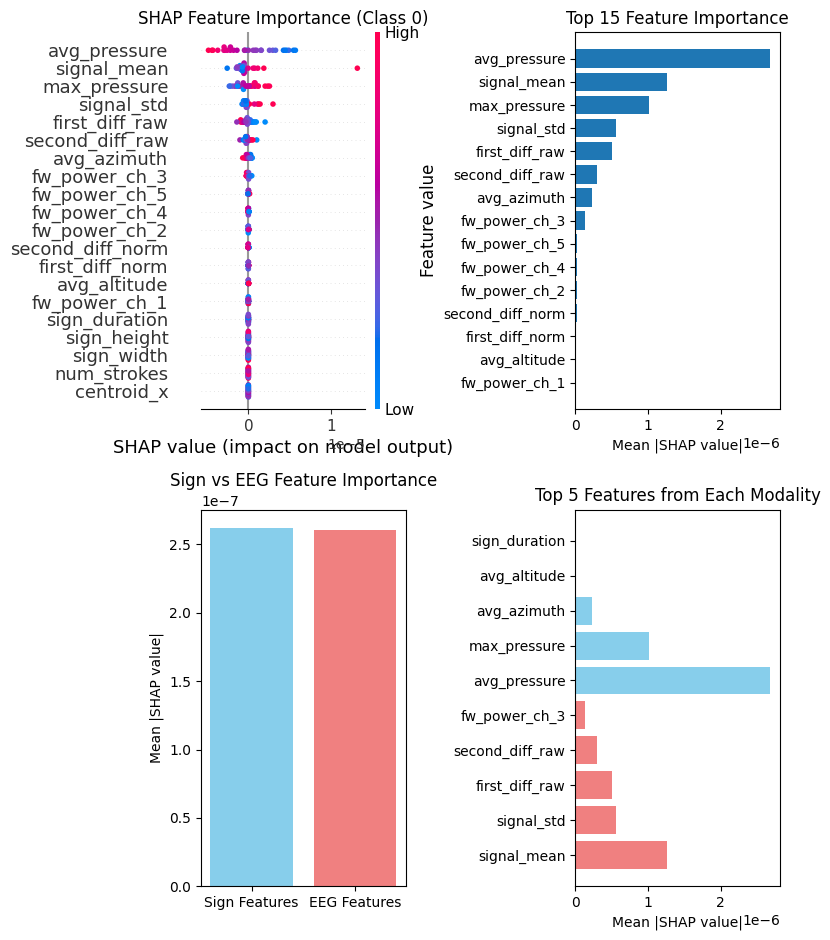


FEATURE IMPORTANCE ANALYSIS

Overall Feature Ranking:
 1. avg_pressure              | 0.000003 | Sign
 2. signal_mean               | 0.000001 | EEG
 3. max_pressure              | 0.000001 | Sign
 4. signal_std                | 0.000001 | EEG
 5. first_diff_raw            | 0.000001 | EEG
 6. second_diff_raw           | 0.000000 | EEG
 7. avg_azimuth               | 0.000000 | Sign
 8. fw_power_ch_3             | 0.000000 | EEG
 9. fw_power_ch_5             | 0.000000 | EEG
10. fw_power_ch_4             | 0.000000 | EEG
11. fw_power_ch_2             | 0.000000 | EEG
12. second_diff_norm          | 0.000000 | EEG
13. first_diff_norm           | 0.000000 | EEG
14. avg_altitude              | 0.000000 | Sign
15. fw_power_ch_1             | 0.000000 | EEG
16. sign_duration             | 0.000000 | Sign
17. sign_height               | 0.000000 | Sign
18. sign_width                | 0.000000 | Sign
19. num_strokes               | 0.000000 | Sign
20. centroid_x                | 0.000000 | S

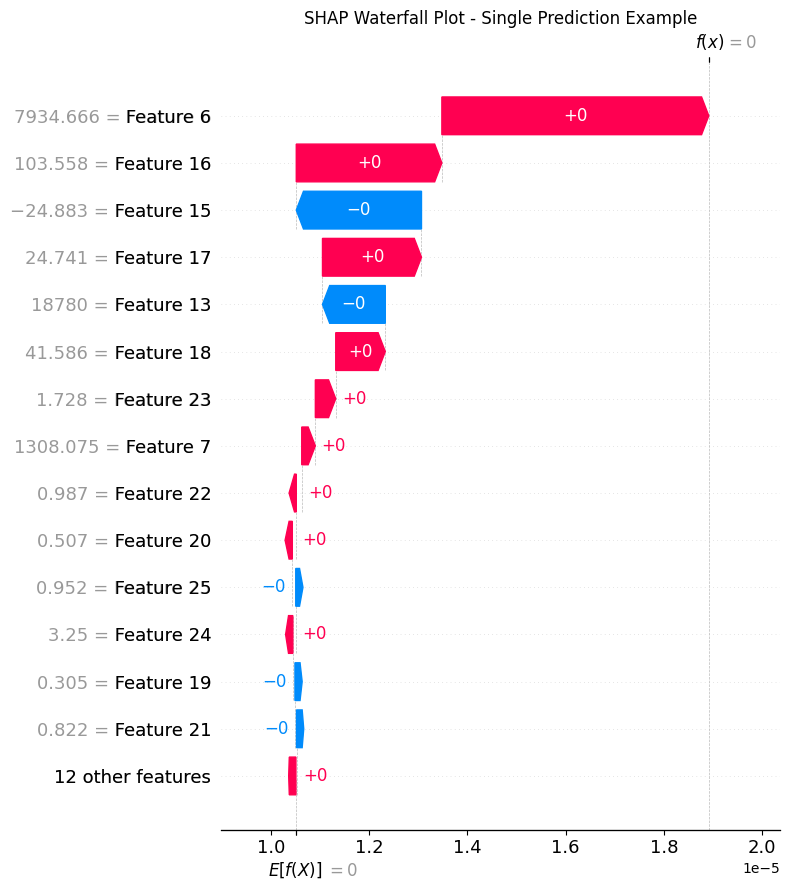

In [ ]:
# Create a wrapper for SHAP analysis
class SHAPModelWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()

    def predict(self, X):
        """
        X should be a numpy array where each row contains:
        [sign_cls_features..., eeg_cls_features...]
        """
        batch_size = X.shape[0]
        # sign_cls_dim = sign_cls_dim  # from your existing variables
        # eeg_cls_dim = eeg_cls_dim    # from your existing variables

        # Split the features back into sign and eeg
        sign_cls_tokens = torch.tensor(X[:, :sign_cls_dim], dtype=torch.float32).to(self.device)
        eeg_cls_tokens = torch.tensor(X[:, sign_cls_dim:], dtype=torch.float32).to(self.device)

        # Create dummy time series data (zeros) since we're only analyzing CLS tokens
        sign_x_ts = torch.zeros((batch_size, sign_seq_len, sign_ts_dim), dtype=torch.float32).to(self.device)
        eeg_x_ts = torch.zeros((batch_size, eeg_seq_len, eeg_ts_dim), dtype=torch.float32).to(self.device)

        # Create attention masks (all ones for CLS tokens, zeros for dummy data)
        sign_attention_mask = torch.zeros((batch_size, sign_seq_len + 1), dtype=torch.float32).to(self.device)
        sign_attention_mask[:, 0] = 1  # CLS token is always attended to
        eeg_attention_mask = torch.zeros((batch_size, eeg_seq_len + 1), dtype=torch.float32).to(self.device)
        eeg_attention_mask[:, 0] = 1   # CLS token is always attended to

        with torch.no_grad():
            logits = self.model(sign_x_ts, sign_cls_tokens, eeg_x_ts, eeg_cls_tokens,
                              sign_attention_mask, eeg_attention_mask)
            probabilities = torch.softmax(logits, dim=1)

        return probabilities.cpu().numpy()

# Prepare data for SHAP analysis
def prepare_shap_data(dataset, max_samples=200):
    """Prepare combined CLS token features for SHAP analysis"""
    sign_cls_features = []
    eeg_cls_features = []
    labels = []

    # Sample data for SHAP (SHAP can be computationally expensive)
    indices = np.random.choice(len(dataset), min(max_samples, len(dataset)), replace=False)

    for idx in indices:
        sample = dataset[idx]
        sign_cls_features.append(sample['sign_cls_token'].numpy())
        eeg_cls_features.append(sample['eeg_cls_token'].numpy())
        labels.append(sample['labels'])

    # Combine sign and eeg features
    sign_cls_features = np.array(sign_cls_features)
    eeg_cls_features = np.array(eeg_cls_features)
    combined_features = np.concatenate([sign_cls_features, eeg_cls_features], axis=1)

    return combined_features, np.array(labels), sign_cls_features.shape[1], eeg_cls_features.shape[1]

# Create feature names for better visualization
def create_feature_names():
    sign_feature_names = [
        'num_strokes', 'sign_height', 'sign_width', 'height_width_ratio',
        'centroid_x', 'centroid_y', 'avg_pressure', 'avg_azimuth', 'avg_altitude',
        'avg_vx', 'avg_vy', 'avg_ax', 'avg_ay', 'max_pressure', 'sign_duration'
    ]

    eeg_feature_names = [
        'signal_mean', 'signal_std', 'first_diff_raw', 'second_diff_raw',
        'first_diff_norm', 'second_diff_norm'
    ]

    # Add frequency-weighted power features for each EEG channel
    num_eeg_channels = eeg_cls_dim - 6  # Subtract the 6 basic features
    for i in range(num_eeg_channels):
        eeg_feature_names.append(f'fw_power_ch_{i+1}')

    return sign_feature_names + eeg_feature_names

# Perform SHAP analysis
print("Preparing data for SHAP analysis...")
shap_data, shap_labels, sign_feat_count, eeg_feat_count = prepare_shap_data(val_dataset, max_samples=100)
feature_names = create_feature_names()

print(f"Sign features: {sign_feat_count}, EEG features: {eeg_feat_count}")
print(f"Total features: {len(feature_names)}")

# Create model wrapper
model_wrapper = SHAPModelWrapper(model, device)

# Create SHAP explainer
print("Creating SHAP explainer...")
explainer = shap.Explainer(model_wrapper.predict, shap_data[:50])  # Use subset as background

# Calculate SHAP values
print("Calculating SHAP values...")
shap_values = explainer(shap_data[:30])  # Analyze subset for computational efficiency

# Visualize results
plt.figure(figsize=(20, 12))

# 1. Summary plot (feature importance)
plt.subplot(2, 2, 1)
shap.summary_plot(shap_values.values[:, :, 0], shap_data[:30],
                  feature_names=feature_names, show=False, max_display=20)
plt.title('SHAP Feature Importance (Class 0)')

plt.subplot(2, 2, 2)
# Feature importance bar plot
mean_shap_values = np.mean(np.abs(shap_values.values[:, :, 0]), axis=0)
feature_importance = list(zip(feature_names, mean_shap_values))
feature_importance.sort(key=lambda x: x[1], reverse=True)

top_features = feature_importance[:15]
features, importances = zip(*top_features)

plt.barh(range(len(features)), importances)
plt.yticks(range(len(features)), features)
plt.xlabel('Mean |SHAP value|')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()

# 3. Separate analysis for Sign vs EEG features
plt.subplot(2, 2, 3)
sign_importances = mean_shap_values[:sign_feat_count]
eeg_importances = mean_shap_values[sign_feat_count:]

categories = ['Sign Features', 'EEG Features']
category_importances = [np.mean(sign_importances), np.mean(eeg_importances)]

plt.bar(categories, category_importances, color=['skyblue', 'lightcoral'])
plt.ylabel('Mean |SHAP value|')
plt.title('Sign vs EEG Feature Importance')

# 4. Top features from each modality
plt.subplot(2, 2, 4)
top_sign_idx = np.argsort(sign_importances)[-5:]
top_eeg_idx = np.argsort(eeg_importances)[-5:] + sign_feat_count

top_sign_features = [feature_names[i] for i in top_sign_idx]
top_eeg_features = [feature_names[i] for i in top_eeg_idx]

all_top_features = top_sign_features + top_eeg_features
all_top_importances = [mean_shap_values[i] for i in top_sign_idx] + [mean_shap_values[i] for i in top_eeg_idx]
colors = ['skyblue'] * 5 + ['lightcoral'] * 5

plt.barh(range(len(all_top_features)), all_top_importances, color=colors)
plt.yticks(range(len(all_top_features)), all_top_features)
plt.xlabel('Mean |SHAP value|')
plt.title('Top 5 Features from Each Modality')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Print detailed results
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

print(f"\nOverall Feature Ranking:")
for i, (feature, importance) in enumerate(feature_importance[:20]):
    modality = "Sign" if feature in feature_names[:sign_feat_count] else "EEG"
    print(f"{i+1:2d}. {feature:25s} | {importance:.6f} | {modality}")

print(f"\nSign Features (Average importance: {np.mean(sign_importances):.6f}):")
sign_ranking = [(feature_names[i], sign_importances[i]) for i in range(sign_feat_count)]
sign_ranking.sort(key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(sign_ranking[:10]):
    print(f"{i+1:2d}. {feature:25s} | {importance:.6f}")

print(f"\nEEG Features (Average importance: {np.mean(eeg_importances):.6f}):")
eeg_ranking = [(feature_names[i], eeg_importances[i-sign_feat_count]) for i in range(sign_feat_count, len(feature_names))]
eeg_ranking.sort(key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(eeg_ranking[:10]):
    print(f"{i+1:2d}. {feature:25s} | {importance:.6f}")

# Additional visualization: Waterfall plot for a single prediction
if len(shap_values.values) > 0:
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(shap_values[0, :, 0], max_display=15, show=False)
    plt.title('SHAP Waterfall Plot - Single Prediction Example')
    plt.tight_layout()
    plt.show()

# Sign + EEG Forgery Detection

In [ ]:
train_files, _, train_labels = get_dataset_files_and_user_ids(data_category=constants.ALL, data_type = constants.TRAIN, task = constants.IDENTIFY)
test_files, _, test_labels = get_dataset_files_and_user_ids(data_category=constants.ALL, data_type=constants.TEST, task = constants.IDENTIFY)
val_files, _, val_labels = get_dataset_files_and_user_ids(data_category=constants.ALL, data_type=constants.VALIDATION, task = constants.IDENTIFY)

print("Train files: ", len(train_files))
print("Test files: ", len(test_files))
print("Val files: ", len(val_files))

raw_train_data = get_sig_eeg_raw_data(train_files, train_labels)
raw_test_data = get_sig_eeg_raw_data(test_files, test_labels)
raw_val_data = get_sig_eeg_raw_data(val_files, val_labels)

Train files:  1138
Test files:  379
Val files:  380


In [ ]:
augmented_raw_data = []
num_augments = 3

for sample in raw_train_data:
    augmented_raw_data.append(sample)
    for _ in range(num_augments):
        aug_sample = sample.copy()
        aug_sample['sign_data'] = augment_sign_data(sample['sign_data'])
        aug_sample['eeg_data'] = augment_eeg_data(sample['eeg_data'])
        augmented_raw_data.append(aug_sample)

raw_train_data = augmented_raw_data
# shuffling to prevent overfitting
random.shuffle(raw_train_data)

for i in range(len(raw_train_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_train_data[i]['sign_data'])
    eeg_data_raw, eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_train_data[i]['eeg_data'])
    # print("EEG Feature data shape: ", eeg_data_with_features.shape)
    raw_train_data[i]['sign_data'] = sign_data_with_features
    raw_train_data[i]['sign_cls_token'] = sign_cls_token
    raw_train_data[i]['eeg_data'] = eeg_data_with_features
    raw_train_data[i]['eeg_cls_token'] = eeg_cls_token

for i in range(len(raw_test_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_test_data[i]['sign_data'])
    eeg_data_raw, eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_test_data[i]['eeg_data'])
    raw_test_data[i]['sign_data'] = sign_data_with_features
    raw_test_data[i]['sign_cls_token'] = sign_cls_token
    raw_test_data[i]['eeg_data'] = eeg_data_with_features
    raw_test_data[i]['eeg_cls_token'] = eeg_cls_token

for i in range(len(raw_val_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_val_data[i]['sign_data'])
    eeg_data_raw, eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_val_data[i]['eeg_data'])
    raw_val_data[i]['sign_data'] = sign_data_with_features
    raw_val_data[i]['sign_cls_token'] = sign_cls_token
    raw_val_data[i]['eeg_data'] = eeg_data_with_features
    raw_val_data[i]['eeg_cls_token'] = eeg_cls_token

sign_max_seq_len = max_seq_len_for_data
eeg_max_seq_len = 5

for i in range(len(raw_train_data)):
    sign_data = raw_train_data[i]['sign_data']
    eeg_data = raw_train_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_train_data[i]['sign_data'] = sign_data
    raw_train_data[i]['eeg_data'] = eeg_data
    raw_train_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_train_data[i]['eeg_attention_mask'] = eeg_attention_mask

for i in range(len(raw_test_data)):
    sign_data = raw_test_data[i]['sign_data']
    eeg_data = raw_test_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_test_data[i]['sign_data'] = sign_data
    raw_test_data[i]['eeg_data'] = eeg_data
    raw_test_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_test_data[i]['eeg_attention_mask'] = eeg_attention_mask

for i in range(len(raw_val_data)):
    sign_data = raw_val_data[i]['sign_data']
    eeg_data = raw_val_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_val_data[i]['sign_data'] = sign_data
    raw_val_data[i]['eeg_data'] = eeg_data
    raw_val_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_val_data[i]['eeg_attention_mask'] = eeg_attention_mask

sign_train_data = [data['sign_data'] for data in raw_train_data]
eeg_train_data = [data['eeg_data'] for data in raw_train_data]
sign_train_attention_masks = [data['sign_attention_mask'] for data in raw_train_data]
eeg_train_attention_masks = [data['eeg_attention_mask'] for data in raw_train_data]
sign_train_cls_tokens = [data['sign_cls_token'] for data in raw_train_data]
eeg_train_cls_tokens = [data['eeg_cls_token'] for data in raw_train_data]
labels_train = [data['label'] for data in raw_train_data]
files_train = [data['file'] for data in raw_train_data]

sign_test_data = [data['sign_data'] for data in raw_test_data]
eeg_test_data = [data['eeg_data'] for data in raw_test_data]
sign_test_attention_masks = [data['sign_attention_mask'] for data in raw_test_data]
eeg_test_attention_masks = [data['eeg_attention_mask'] for data in raw_test_data]
sign_test_cls_tokens = [data['sign_cls_token'] for data in raw_test_data]
eeg_test_cls_tokens = [data['eeg_cls_token'] for data in raw_test_data]
labels_test = [data['label'] for data in raw_test_data]
files_test = [data['file'] for data in raw_test_data]

sign_val_data = [data['sign_data'] for data in raw_val_data]
eeg_val_data = [data['eeg_data'] for data in raw_val_data]
sign_val_attention_masks = [data['sign_attention_mask'] for data in raw_val_data]
eeg_val_attention_masks = [data['eeg_attention_mask'] for data in raw_val_data]
eeg_val_cls_tokens = [data['eeg_cls_token'] for data in raw_val_data]
sign_val_cls_tokens = [data['sign_cls_token'] for data in raw_val_data]
labels_val = [data['label'] for data in raw_val_data]
files_val = [data['file'] for data in raw_val_data]

train_input = {
    'sign_data': sign_train_data,
    'eeg_data': eeg_train_data,
    'sign_attention_masks': sign_train_attention_masks,
    'eeg_attention_masks': eeg_train_attention_masks,
    'sign_cls_tokens': sign_train_cls_tokens,
    'eeg_cls_tokens': eeg_train_cls_tokens,
    'labels': labels_train,
}

test_input = {
    'sign_data': sign_test_data,
    'eeg_data': eeg_test_data,
    'sign_attention_masks': sign_test_attention_masks,
    'eeg_attention_masks': eeg_test_attention_masks,
    'sign_cls_tokens': sign_test_cls_tokens,
    'eeg_cls_tokens': eeg_test_cls_tokens,
    'labels': labels_test,
}

val_input = {
    'sign_data': sign_val_data,
    'eeg_data': eeg_val_data,
    'sign_attention_masks': sign_val_attention_masks,
    'eeg_attention_masks': eeg_val_attention_masks,
    'sign_cls_tokens': sign_val_cls_tokens,
    'eeg_cls_tokens': eeg_val_cls_tokens,
    'labels': labels_val,
}

/tmp/ipython-input-10-1646318677.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_sign_data = torch.tensor(normalized_sign_data, dtype=torch.float32)
/tmp/ipython-input-15-4004042047.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 136, using nperseg = 136
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
/tmp/ipython-input-15-4004042047.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 203, using nperseg = 203
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
/tmp/ipython-input-15-4004042047.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 197, using nperseg = 197
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)


In [ ]:
print("Sign train data type: ", type(sign_train_data))
print("EEG train data type: ", type(eeg_train_data))
print("Sign train data type: ", type(sign_train_attention_masks[0]))
print("EEG train data type: ", type(eeg_train_attention_masks[0]))
print("Sign train cls tokens type: ", type(sign_train_cls_tokens[0]))
print("EEG train cls tokens type: ", type(eeg_train_cls_tokens[0]))

print("Sign train data shape: ", sign_train_data[0].shape)
print("EEG train data shape: ", eeg_train_data[0].shape)
print("Sign train attention mask shape: ", sign_train_attention_masks[0].shape)
print("EEG train attention mask shape: ", eeg_train_attention_masks[0].shape)
print("Train labels length: ", len(labels_train))
print("Test labels length: ", len(labels_test))
print("Train labels: ", labels_train[:10])
print("Test labels: ", labels_test[:10])

print("Num signs: ", len(sign_train_data))

Sign train data type:  <class 'list'>
EEG train data type:  <class 'list'>
Sign train data type:  <class 'torch.Tensor'>
EEG train data type:  <class 'torch.Tensor'>
Sign train cls tokens type:  <class 'torch.Tensor'>
EEG train cls tokens type:  <class 'torch.Tensor'>
Sign train data shape:  torch.Size([3000, 11])
EEG train data shape:  torch.Size([5, 325])
Sign train attention mask shape:  torch.Size([3001])
EEG train attention mask shape:  torch.Size([6])
Train labels length:  4540
Test labels length:  379
Train labels:  [1, 0, 1, 1, 0, 1, 0, 0, 0, 1]
Test labels:  [1, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Num signs:  4540


In [ ]:
sign_ts_dim = sign_train_data[0].size(1)
sign_cls_dim = sign_train_cls_tokens[0].size(0)
sign_seq_len = sign_train_data[0].size(0)
eeg_ts_dim = eeg_train_data[0].size(1)
eeg_cls_dim = eeg_train_cls_tokens[0].size(0)
eeg_seq_len = eeg_train_data[0].size(0)

In [ ]:
batch_size = 16
d_model = 256
num_classes = 2
num_heads = 4
num_layers = 4
num_epochs = 25

train_loader = DataLoader(SignatureEEGDataset(train_input, num_classes), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(SignatureEEGDataset(test_input, num_classes), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(SignatureEEGDataset(val_input, num_classes), batch_size=batch_size, shuffle=False)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SignatureEEGTransformer(
    sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
    eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
    d_model=d_model, num_classes=num_classes, num_heads=num_heads, num_layers=num_layers,
    sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4) # weight_decay is for L2 regularization, to prevent overfitting
loss_fn = nn.CrossEntropyLoss()

# best_loss = float('inf')
# patience = 5
# counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss, train_labels, train_preds = 0, [], []
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
        sign_x_ts = batch['sign_x_ts'].to(device)
        sign_cls_token = batch['sign_cls_token'].to(device)
        sign_attention_mask = batch['sign_attention_mask'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        eeg_cls_token = batch['eeg_cls_token'].to(device)
        eeg_attention_mask = batch['eeg_attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(preds.cpu().numpy())
    print("Train labels: ", train_labels[:10])
    print("Pred labels: ", train_preds[:10])

    avg_train_loss = train_loss / len(train_labels)
    train_acc = accuracy_score(train_labels, train_preds)

    model.eval()
    test_loss, test_labels, test_preds = 0, [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch+1} Testing", leave=False):
            sign_x_ts = batch['sign_x_ts'].to(device)
            sign_cls_token = batch['sign_cls_token'].to(device)
            sign_attention_mask = batch['sign_attention_mask'].to(device)
            eeg_x_ts = batch['eeg_x_ts'].to(device)
            eeg_cls_token = batch['eeg_cls_token'].to(device)
            eeg_attention_mask = batch['eeg_attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
            loss = loss_fn(logits, labels)
            test_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(preds.cpu().numpy())
    print("Test labels: ", test_labels[:10])
    print("Pred labels: ", test_preds[:10])

    avg_test_loss = test_loss / len(test_labels)
    test_acc = accuracy_score(test_labels, test_preds)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.4f}")
    print(f"Test F1 Score: {f1_score(test_labels, test_preds, average='weighted'):.4f}")
    print("="*50)

    # Store metrics for plotting
    if epoch == 0:
        history = {
            'train_loss': [],
            'test_loss': [],
            'train_acc': [],
            'test_acc': [],
            'test_f1': []
        }
    history['train_loss'].append(avg_train_loss)
    history['test_loss'].append(avg_test_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)
    history['test_f1'].append(f1_score(test_labels, test_preds, average='weighted'))

    # if test_loss < best_loss:
    #     best_loss = test_loss
    #     counter = 0
    # else:
    #     counter += 1
    #     if counter >= patience:
    #         print("Model may be overfitting, time to early stop: ")
    #         break

Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/25
Train Loss: 0.6458 | Train Acc: 0.6216
Test Loss: 0.6170 | Test Acc: 0.6596
Test F1 Score: 0.6560


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/25
Train Loss: 0.5844 | Train Acc: 0.6826
Test Loss: 0.5735 | Test Acc: 0.7018
Test F1 Score: 0.6979


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/25
Train Loss: 0.5429 | Train Acc: 0.7240
Test Loss: 0.5645 | Test Acc: 0.6860
Test F1 Score: 0.6854


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/25
Train Loss: 0.5205 | Train Acc: 0.7357
Test Loss: 0.5771 | Test Acc: 0.6939
Test F1 Score: 0.6942


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/25
Train Loss: 0.4869 | Train Acc: 0.7621
Test Loss: 0.5691 | Test Acc: 0.6992
Test F1 Score: 0.6980


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/25
Train Loss: 0.4622 | Train Acc: 0.7817
Test Loss: 0.5953 | Test Acc: 0.6939
Test F1 Score: 0.6807


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/25
Train Loss: 0.4505 | Train Acc: 0.7833
Test Loss: 0.5573 | Test Acc: 0.7388
Test F1 Score: 0.7390


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/25
Train Loss: 0.4191 | Train Acc: 0.8066
Test Loss: 0.6245 | Test Acc: 0.7098
Test F1 Score: 0.7088


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/25
Train Loss: 0.4022 | Train Acc: 0.8176
Test Loss: 0.5920 | Test Acc: 0.7282
Test F1 Score: 0.7282


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 10/25
Train Loss: 0.3876 | Train Acc: 0.8222
Test Loss: 0.6087 | Test Acc: 0.7203
Test F1 Score: 0.7198


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 11/25
Train Loss: 0.3553 | Train Acc: 0.8427
Test Loss: 0.7225 | Test Acc: 0.7150
Test F1 Score: 0.7113


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 12/25
Train Loss: 0.3555 | Train Acc: 0.8447
Test Loss: 0.5924 | Test Acc: 0.7203
Test F1 Score: 0.7165


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 13/25
Train Loss: 0.3302 | Train Acc: 0.8575
Test Loss: 0.6291 | Test Acc: 0.7071
Test F1 Score: 0.7046


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 14/25
Train Loss: 0.3083 | Train Acc: 0.8707
Test Loss: 0.6299 | Test Acc: 0.7282
Test F1 Score: 0.7239


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 15/25
Train Loss: 0.3026 | Train Acc: 0.8720
Test Loss: 0.6918 | Test Acc: 0.6913
Test F1 Score: 0.6872


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 16/25
Train Loss: 0.2751 | Train Acc: 0.8866
Test Loss: 0.6974 | Test Acc: 0.7414
Test F1 Score: 0.7411


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 17/25
Train Loss: 0.2620 | Train Acc: 0.8934
Test Loss: 0.7482 | Test Acc: 0.7150
Test F1 Score: 0.7130


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 18/25
Train Loss: 0.2442 | Train Acc: 0.9037
Test Loss: 0.7593 | Test Acc: 0.7124
Test F1 Score: 0.7097


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 19/25
Train Loss: 0.2363 | Train Acc: 0.9055
Test Loss: 0.7481 | Test Acc: 0.7282
Test F1 Score: 0.7243


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 20/25
Train Loss: 0.2188 | Train Acc: 0.9159
Test Loss: 0.8342 | Test Acc: 0.7256
Test F1 Score: 0.7214


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 21/25
Train Loss: 0.2109 | Train Acc: 0.9176
Test Loss: 0.9173 | Test Acc: 0.7282
Test F1 Score: 0.7284


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 22/25
Train Loss: 0.1999 | Train Acc: 0.9196
Test Loss: 0.9379 | Test Acc: 0.7256
Test F1 Score: 0.7255


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 23/25
Train Loss: 0.1880 | Train Acc: 0.9278
Test Loss: 0.9487 | Test Acc: 0.6992
Test F1 Score: 0.6933


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 24/25
Train Loss: 0.1967 | Train Acc: 0.9256
Test Loss: 0.9693 | Test Acc: 0.7045
Test F1 Score: 0.7000


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 25/25
Train Loss: 0.1624 | Train Acc: 0.9385
Test Loss: 0.9600 | Test Acc: 0.7203
Test F1 Score: 0.7197


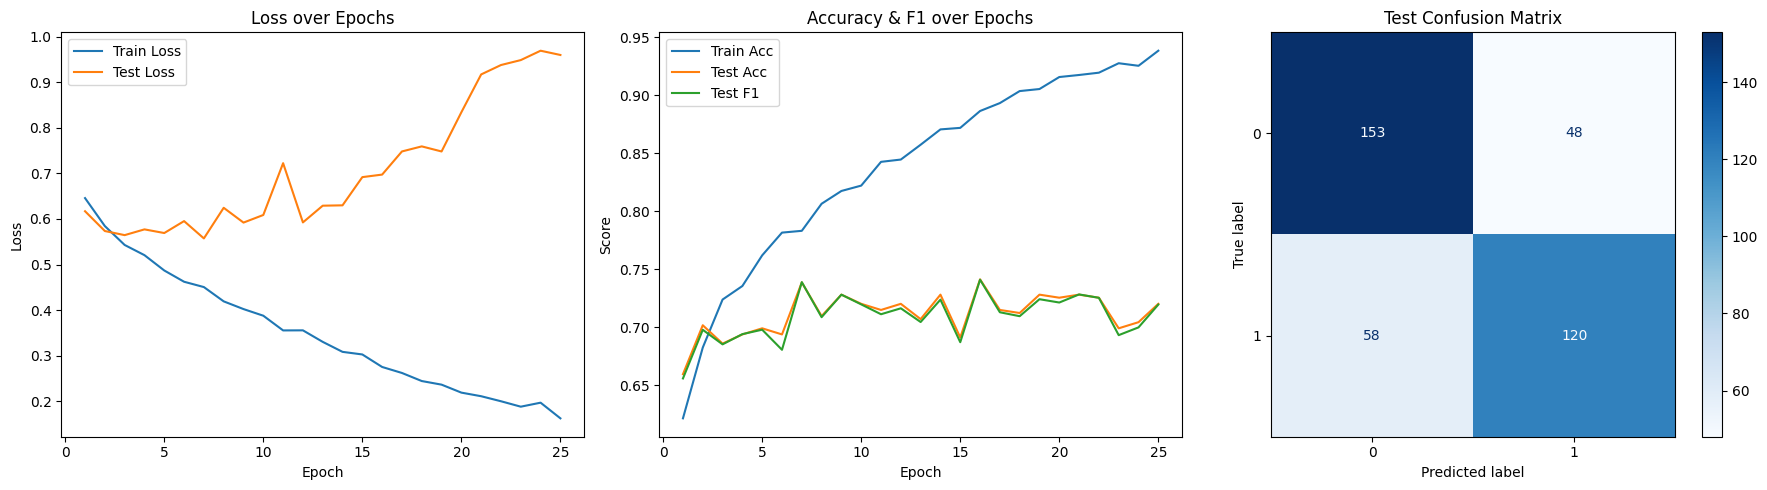

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['test_acc'], label='Test Acc')
plt.plot(epochs, history['test_f1'], label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Accuracy & F1 over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, cmap='Blues', ax=plt.gca())
plt.title('Test Confusion Matrix')

plt.tight_layout()
plt.show()

torch.save(model.state_dict(), f"/content/drive/MyDrive/dataset-final-project/forgery-model/forgery_model_{datetime.now().strftime('%m%d%Y-%H%M%S')}.pth")
# torch.save(model.state_dict(), os.path.join(os.getenv("MODEL_PATH"), f"multimodal_model_{datetime.now().strftime('%m%d%Y-%H%M%S')}.pth"))

In [ ]:
print(history)

{'train_loss': [0.5745288943786071, 0.47318450171540727, 0.41117847509082434, 0.36110928735711073, 0.31777375354246945, 0.2800721627100258], 'test_loss': [0.590848282962487, 0.6172190133609998, 0.641930687651628, 0.6819166986954873, 0.7083314655245452, 0.8247748450732404], 'train_acc': [0.6896275530636764, 0.7712454945935122, 0.8129755706848217, 0.8411694032839407, 0.868241890268322, 0.8882659191029235], 'test_acc': [0.712401055408971, 0.712401055408971, 0.7282321899736148, 0.7361477572559367, 0.7546174142480211, 0.7493403693931399], 'test_f1': [0.7045452423095135, 0.7124851504239937, 0.7283116559052417, 0.7296599618499355, 0.7522703535727733, 0.7488341886880712]}


In [ ]:
model.eval()
val_loss = 0
val_labels = []
val_preds = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validation", leave=False):
        sign_x_ts = batch['sign_x_ts'].to(device)
        sign_cls_token = batch['sign_cls_token'].to(device)
        sign_attention_mask = batch['sign_attention_mask'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        eeg_cls_token = batch['eeg_cls_token'].to(device)
        eeg_attention_mask = batch['eeg_attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
        loss = loss_fn(logits, labels)
        val_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        val_labels.extend(labels.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())

avg_val_loss = val_loss / len(val_labels)
val_acc = accuracy_score(val_labels, val_preds)
val_prec = precision_score(val_labels, val_preds, zero_division=0, average='macro')
val_rec = recall_score(val_labels, val_preds, zero_division=0, average='macro')
val_f1 = f1_score(val_labels, val_preds, zero_division=0, average='macro')

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_prec:.4f}")
print(f"Validation Recall: {val_rec:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

Validation Loss: 0.8375
Validation Accuracy: 0.7487
Validation Precision: 0.7665
Validation Recall: 0.7500
Validation F1 Score: 0.7451


# Sign + EEG anomaly detection - Transformer

In [ ]:
class AnomalyDataset(Dataset):
    def __init__(self, input_data, num_classes):
        sign_data = input_data['sign_data']
        eeg_data = input_data['eeg_data']
        sign_attention_masks = input_data['sign_attention_masks']
        eeg_attention_masks = input_data['eeg_attention_masks']
        # sign_cls_tokens = input_data['sign_cls_tokens']
        # eeg_cls_tokens = input_data['eeg_cls_tokens']
        labels = input_data['labels']

        self.sign_x_ts = sign_data
        # self.sign_cls_token = sign_cls_tokens
        self.sign_attention_mask = sign_attention_masks
        self.sign_seq_len = sign_data[0].shape[0]
        self.sign_ts_dim = sign_data[0].shape[1]

        self.eeg_x_ts = eeg_data
        # self.eeg_cls_token = eeg_cls_tokens
        self.eeg_attention_mask = eeg_attention_masks
        self.eeg_seq_len = eeg_data[0].shape[0]
        self.eeg_ts_dim = eeg_data[0].shape[1]

        self.num_classes = num_classes
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'sign_x_ts': self.sign_x_ts[idx],
            # 'sign_cls_token': self.sign_cls_token[idx],
            'sign_attention_mask': self.sign_attention_mask[idx],
            'eeg_x_ts': self.eeg_x_ts[idx],
            # 'eeg_cls_token': self.eeg_cls_token[idx],
            'eeg_attention_mask': self.eeg_attention_mask[idx],
            'labels': self.labels[idx],
        }

In [ ]:

files_mat_genuine_train, user_ids_genuine_train, train_labels = get_dataset_files_and_user_ids(data_category=constants.GENUINE, data_type=constants.TRAIN)
files_mat_test, user_ids_test, test_labels = get_dataset_files_and_user_ids(data_category=constants.ALL, data_type=constants.TEST)

raw_data_train = get_sig_eeg_raw_data(files_mat_genuine_train, train_labels)
raw_data_test = get_sig_eeg_raw_data(files_mat_test, test_labels)

sign_max_seq_len = max_seq_len_for_data
eeg_max_seq_len = int(max_seq_len_for_data // 2)

for i in range(len(raw_data_train)):
    sign_feat, _ = get_sign_data_features(raw_data_train[i]['sign_data'])
    eeg_data, _, _ = get_eeg_data_features(raw_data_train[i]['eeg_data'])
    sign_feat, sign_mask = attach_attention_tokens_and_padding(sign_feat, sign_max_seq_len)
    eeg_data, eeg_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_data_train[i]['sign_data'] = sign_feat
    raw_data_train[i]['eeg_data'] = eeg_data
    raw_data_train[i]['sign_attention_mask'] = sign_mask
    raw_data_train[i]['eeg_attention_mask'] = eeg_mask

for i in range(len(raw_data_test)):
    sign_feat, _ = get_sign_data_features(raw_data_test[i]['sign_data'])
    eeg_data, _, _ = get_eeg_data_features(raw_data_test[i]['eeg_data'])
    sign_feat, sign_mask = attach_attention_tokens_and_padding(sign_feat, sign_max_seq_len)
    eeg_data, eeg_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_data_test[i]['sign_data'] = sign_feat
    raw_data_test[i]['eeg_data'] = eeg_data
    raw_data_test[i]['sign_attention_mask'] = sign_mask
    raw_data_test[i]['eeg_attention_mask'] = eeg_mask

sign_data_train = [d['sign_data'] for d in raw_data_train]
eeg_data_train = [d['eeg_data'] for d in raw_data_train]
sign_attention_masks_train = [d['sign_attention_mask'][1:] for d in raw_data_train]
eeg_attention_masks_train = [d['eeg_attention_mask'][1:] for d in raw_data_train]
labels_train = [d['label'] for d in raw_data_train]

sign_data_test = [d['sign_data'] for d in raw_data_test]
eeg_data_test = [d['eeg_data'] for d in raw_data_test]
sign_attention_masks_test = [d['sign_attention_mask'][1:] for d in raw_data_test]
eeg_attention_masks_test = [d['eeg_attention_mask'][1:] for d in raw_data_test]
labels_test = [d['label'] for d in raw_data_test]

In [ ]:
input_data_train = {
    'sign_data': sign_data_train,
    'eeg_data': eeg_data_train,
    'sign_attention_masks': sign_attention_masks_train,
    'eeg_attention_masks': eeg_attention_masks_train,
    'labels': labels_train,
}
input_data_test = {
    'sign_data': sign_data_test,
    'eeg_data': eeg_data_test,
    'sign_attention_masks': sign_attention_masks_test,
    'eeg_attention_masks': eeg_attention_masks_test,
    'labels': labels_test,
}
anomaly_train_dataset = AnomalyDataset(input_data_train, num_classes=1)
anomaly_test_dataset = AnomalyDataset(input_data_test, num_classes=1)
anomaly_train_loader = DataLoader(anomaly_train_dataset, batch_size=16, shuffle=True)
anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=16, shuffle=False)
sign_ts_dim_train = input_data_train['sign_data'][0].size(1)
# sign_attention_masks_train = input_data_train['sign_attention_masks'][0].size(0)
sign_seq_len_train = input_data_train['sign_data'][0].size(0)
eeg_ts_dim_train = input_data_train['eeg_data'][0].size(1)
# eeg_attention_masks_train = input_data_train['eeg_attention_masks'][0].size(0)
eeg_seq_len_train = input_data_train['eeg_data'][0].size(0)

sign_ts_dim_test = input_data_test['sign_data'][0].size(1)
# sign_attention_masks_test = input_data_test['sign_attention_masks'][0].size(0)
sign_seq_len_test = input_data_test['sign_data'][0].size(0)
eeg_ts_dim_test = input_data_test['eeg_data'][0].size(1)
# eeg_attention_masks_test = input_data_test['eeg_attention_masks'][0].size(0)
eeg_seq_len_test = input_data_test['eeg_data'][0].size(0)


In [ ]:
# print("Sign data type: ", eeg_data_train[0])
# print("EEG data type: ", type(eeg_data))
# print("Sign attention mask type: ", type(sign_attention_masks[0]))
# print("EEG attention mask type: ", type(eeg_attention_masks[0]))
# print("Sign cls token type: ", type(sign_cls_tokens[0]))
# print("EEG cls token type: ", type(eeg_cls_tokens[0]))
# print("Labels type: ", type(labels))
# print("Files type: ", type(files))


print("Sign data shape: ", sign_data_train[0].shape)
print("EEG data shape: ", eeg_data_train[0].shape)
print("Sign attention mask shape: ", sign_attention_masks_train[0].shape)
print("EEG attention mask shape: ", eeg_attention_masks_train[0].shape)
# print("Sign cls token shape: ", sign_cls_tokens_train[0].shape)
# print("EEG cls token shape: ", eeg_cls_tokens_train[0].shape)
print("Labels shape: ", len(labels_train))
print("Labels unique elements: ", set(labels_train))
# print("Files shape: ", len(files_train))

In [ ]:
# print(torch.isnan(sign_x_ts).any(), torch.isinf(sign_x_ts).any())
# print(torch.isnan(eeg_x_ts).any(), torch.isinf(eeg_x_ts).any())

In [ ]:
class SignEEGTransformerAutoEncoder(nn.Module):
    def __init__(self, sign_input_dim, sign_seq_len, eeg_input_dim, eeg_seq_len, d_model=128, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.sign_input_proj = nn.Linear(sign_input_dim, d_model)
        self.sign_pos_enc = PositionalEncoding(d_model, sign_seq_len)
        sign_encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads, dropout=dropout, batch_first=True)
        self.sign_encoder = nn.TransformerEncoder(sign_encoder_layer, num_layers=num_layers)
        sign_decoder_layer = nn.TransformerDecoderLayer(d_model, num_heads, dropout=dropout, batch_first=True)
        self.sign_decoder = nn.TransformerDecoder(sign_decoder_layer, num_layers=num_layers)
        self.sign_output_proj = nn.Linear(d_model, sign_input_dim)

        self.eeg_input_proj = nn.Linear(eeg_input_dim, d_model)
        self.eeg_pos_enc = PositionalEncoding(d_model, eeg_seq_len)
        eeg_encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads, dropout=dropout, batch_first=True)
        self.eeg_encoder = nn.TransformerEncoder(eeg_encoder_layer, num_layers=num_layers)
        eeg_decoder_layer = nn.TransformerDecoderLayer(d_model, num_heads, dropout=dropout, batch_first=True)
        self.eeg_decoder = nn.TransformerDecoder(eeg_decoder_layer, num_layers=num_layers)
        self.eeg_output_proj = nn.Linear(d_model, eeg_input_dim)

    def forward(self, sign_x, eeg_x, sign_attn_mask=None, eeg_attn_mask=None):
        sign_x_proj = self.sign_input_proj(sign_x) + self.sign_pos_enc(sign_x)
        sign_memory = self.sign_encoder(sign_x_proj, src_key_padding_mask=sign_attn_mask)
        sign_decoded = self.sign_decoder(sign_x_proj, sign_memory, tgt_key_padding_mask=sign_attn_mask, memory_key_padding_mask=sign_attn_mask)
        sign_recon = self.sign_output_proj(sign_decoded)
        eeg_x_proj = self.eeg_input_proj(eeg_x) + self.eeg_pos_enc(eeg_x)
        eeg_memory = self.eeg_encoder(eeg_x_proj, src_key_padding_mask=eeg_attn_mask)
        eeg_decoded = self.eeg_decoder(eeg_x_proj, eeg_memory, tgt_key_padding_mask=eeg_attn_mask, memory_key_padding_mask=eeg_attn_mask)
        eeg_recon = self.eeg_output_proj(eeg_decoded)

        return sign_recon, eeg_recon

In [ ]:
def train_validate_autoencoder(model, train_loader, val_loader, device, num_epochs=20, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
            sign_x = batch['sign_x_ts'].to(device)
            sign_mask = batch['sign_attention_mask'].to(device) if 'sign_attention_mask' in batch else None
            if sign_mask.dim() == 3:
                sign_mask = sign_mask.squeeze(1) if sign_mask is not None else None
            eeg_x = batch['eeg_x_ts'].to(device)
            eeg_mask = batch['eeg_attention_mask'].to(device) if 'eeg_attention_mask' in batch else None
            if eeg_mask.dim() == 3:
                eeg_mask = eeg_mask.squeeze(1) if eeg_mask is not None else None

            optimizer.zero_grad()
            sign_recon, eeg_recon = model(sign_x, eeg_x, sign_mask, eeg_mask)
            loss_sign = loss_fn(sign_recon, sign_x)
            loss_eeg = loss_fn(eeg_recon, eeg_x)
            loss = loss_sign + loss_eeg
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
                sign_x = batch['sign_x_ts'].to(device)
                sign_mask = batch['sign_attention_mask'].to(device) if 'sign_attention_mask' in batch else None
                if sign_mask.dim() == 3:
                    sign_mask = sign_mask.squeeze(1) if sign_mask is not None else None
                eeg_x = batch['eeg_x_ts'].to(device)
                eeg_mask = batch['eeg_attention_mask'].to(device) if 'eeg_attention_mask' in batch else None
                if eeg_mask.dim() == 3:
                    eeg_mask = eeg_mask.squeeze(1) if eeg_mask is not None else None

                sign_recon, eeg_recon = model(sign_x, eeg_x, sign_mask, eeg_mask)
                loss_sign = loss_fn(sign_recon, sign_x)
                loss_eeg = loss_fn(eeg_recon, eeg_x)
                loss = loss_sign + loss_eeg
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader.dataset)
        print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f}")
    return model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
anomaly_model = SignEEGTransformerAutoEncoder(sign_input_dim=sign_ts_dim_train, sign_seq_len=sign_seq_len_train, eeg_input_dim=eeg_ts_dim_train, eeg_seq_len=eeg_seq_len_train, d_model=128, num_heads=4, num_layers=2).to(device)

model = train_validate_autoencoder(anomaly_model, anomaly_train_loader, anomaly_test_loader, device, num_epochs=10, lr=1e-5)

In [ ]:
# model = SignEEGTransformerAutoEncoder(
#     sign_input_dim=sign_ts_dim_test,
#     sign_seq_len=sign_seq_len_test,
#     eeg_input_dim=eeg_ts_dim_test,
#     eeg_seq_len=eeg_seq_len_test,
#     d_model=128,
#     num_heads=4,
#     num_layers=2
# )
# model.load_state_dict(torch.load("D:\\KCL Final Year Individual Project\\Implementation\\Project Implementation\models\\anomaly_model_07212025-153342.pth", map_location='cpu'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=16, shuffle=False)

model.to(device)
model.eval()
all_scores = []
all_labels = []

with torch.no_grad():
    for batch in anomaly_test_loader:
        sign_x_ts = batch['sign_x_ts'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        sign_attention_mask = batch['sign_attention_mask'].to(device)
        eeg_attention_mask = batch['eeg_attention_mask'].to(device)
        labels = torch.tensor(batch['labels'], dtype=torch.float32).to(device)
        sign_recon, eeg_recon = model(sign_x_ts, eeg_x_ts, sign_attention_mask, eeg_attention_mask)
        sign_error = ((sign_recon - sign_x_ts) ** 2).max(dim=(1, 2)).cpu().numpy()
        eeg_error = ((eeg_recon - eeg_x_ts) ** 2).max(dim=(1, 2)).cpu().numpy()
        scores = sign_error + eeg_error
        all_scores.extend(scores)
        all_labels.extend(labels.cpu().numpy())

all_scores_np = np.array(all_scores)
all_labels_np = np.array(all_labels)
fpr, tpr, thresholds = roc_curve(all_labels_np, all_scores_np)
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]
# print("Optimal threshold:", optimal_threshold)
preds = (np.array(all_scores) > threshold).astype(int)
roc = roc_auc_score(all_labels, all_scores)
acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds, zero_division=0)
rec = recall_score(all_labels, preds, zero_division=0)
f1 = f1_score(all_labels, preds, zero_division=0)

print(f"ROC AUC: {roc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, preds, target_names=['Genuine', 'Anomaly'], labels=[0,1]))
print("Confusion Matrix:\n", confusion_matrix(all_labels, preds))

plt.hist(np.array(all_scores)[np.array(all_labels)==0], bins=50, alpha=0.5, label='Genuine')
plt.hist(np.array(all_scores)[np.array(all_labels)==1], bins=50, alpha=0.5, label='Anomaly')
plt.legend()
plt.title("Anomaly Scores Distribution")
plt.show()

## Sign + EEG Anomaly - CNN

In [ ]:
class AnomalyCNNDataset(Dataset):
    def __init__(self, input_data):
        sign_data = input_data['sign_data']
        eeg_data = input_data['eeg_data']
        labels = input_data['labels']

        self.sign_x_ts = sign_data
        # # self.sign_cls_token = sign_cls_tokens
        # self.sign_attention_mask = sign_attention_masks
        self.sign_seq_len = sign_data[0].shape[0]
        self.sign_ts_dim = sign_data[0].shape[1]

        self.eeg_x_ts = eeg_data
        # # self.eeg_cls_token = eeg_cls_tokens
        # self.eeg_attention_mask = eeg_attention_masks
        self.eeg_seq_len = eeg_data[0].shape[0]
        self.eeg_ts_dim = eeg_data[0].shape[1]

        # self.num_classes = num_classes
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'sign_x_ts': self.sign_x_ts[idx],
            # # 'sign_cls_token': self.sign_cls_token[idx],
            # 'sign_attention_mask': self.sign_attention_mask[idx],
            'eeg_x_ts': self.eeg_x_ts[idx],
            # # 'eeg_cls_token': self.eeg_cls_token[idx],
            # 'eeg_attention_mask': self.eeg_attention_mask[idx],
            'labels': self.labels[idx],
        }

In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, latent_dim, kernel_size=3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        z = self.encoder(x)
        return z.squeeze(-1)

In [ ]:
class CNNDecoder(nn.Module):
    def __init__(self, latent_dim, output_dim, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * (seq_len // 4)),
            nn.ReLU(),
            nn.Unflatten(1, (32, seq_len // 4)),
            nn.ConvTranspose1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, output_dim, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, z):
        x = self.decoder(z)
        return x.permute(0, 2, 1)

In [ ]:
class SignEEGCNNAutoencoder(nn.Module):
    def __init__(self, sign_input_dim, eeg_input_dim, sign_seq_len, eeg_seq_len, latent_dim=32):
        super().__init__()
        self.sign_encoder = CNNEncoder(sign_input_dim, latent_dim)
        self.eeg_encoder = CNNEncoder(eeg_input_dim, latent_dim)
        self.sign_decoder = CNNDecoder(latent_dim, sign_input_dim, sign_seq_len)
        self.eeg_decoder = CNNDecoder(latent_dim, eeg_input_dim, eeg_seq_len)

    def forward(self, sign_x, eeg_x):
        sign_z = self.sign_encoder(sign_x)
        eeg_z = self.eeg_encoder(eeg_x)
        sign_recon = self.sign_decoder(sign_z)
        eeg_recon = self.eeg_decoder(eeg_z)
        return sign_recon, eeg_recon

In [ ]:
def train_validate_autoencoder(model, train_loader, device, num_epochs=10, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
            # print("Current batch sign seq len: ", batch['sign_x_ts'].shape[1])
            # print("Current batch eeg seq len: ", batch['eeg_x_ts'].shape[1])
            sign_x = batch['sign_x_ts'].to(device)
            # sign_mask = batch['sign_attention_mask'].to(device) if 'sign_attention_mask' in batch else None
            # if sign_mask.dim() == 3:
            #     sign_mask = sign_mask.squeeze(1) if sign_mask is not None else None
            eeg_x = batch['eeg_x_ts'].to(device)
            # eeg_mask = batch['eeg_attention_mask'].to(device) if 'eeg_attention_mask' in batch else None
            # if eeg_mask.dim() == 3:
            #     eeg_mask = eeg_mask.squeeze(1) if eeg_mask is not None else None

            optimizer.zero_grad()
            sign_recon, eeg_recon = model(sign_x, eeg_x)
            loss_sign = loss_fn(sign_recon, sign_x)
            loss_eeg = loss_fn(eeg_recon, eeg_x)
            loss = loss_sign + loss_eeg
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")

        # model.eval()
        # val_loss = 0
        # with torch.no_grad():
        #     for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
        #         sign_x = batch['sign_x_ts'].to(device)
        #         # sign_mask = batch['sign_attention_mask'].to(device) if 'sign_attention_mask' in batch else None
        #         # if sign_mask.dim() == 3:
        #         #     sign_mask = sign_mask.squeeze(1) if sign_mask is not None else None
        #         eeg_x = batch['eeg_x_ts'].to(device)
        #         # eeg_mask = batch['eeg_attention_mask'].to(device) if 'eeg_attention_mask' in batch else None
        #         # if eeg_mask.dim() == 3:
        #         #     eeg_mask = eeg_mask.squeeze(1) if eeg_mask is not None else None

        #         sign_recon, eeg_recon = model(sign_x, eeg_x)
        #         loss_sign = loss_fn(sign_recon, sign_x)
        #         loss_eeg = loss_fn(eeg_recon, eeg_x)
        #         loss = loss_sign + loss_eeg
        #         val_loss += loss.item()
        # avg_val_loss = val_loss / len(val_loader.dataset)
        # print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f}")
    return model

In [ ]:
files_mat_genuine_train, user_ids_genuine_train, train_labels = get_dataset_files_and_user_ids(data_category=constants.GENUINE, data_type=constants.TRAIN)
files_mat_test, user_ids_test, test_labels = get_dataset_files_and_user_ids(data_category=constants.ALL, data_type=constants.TEST)

raw_data_train = get_sig_eeg_raw_data(files_mat_genuine_train, train_labels)
raw_data_test = get_sig_eeg_raw_data(files_mat_test, test_labels)

sign_max_seq_len = max_seq_len_for_data
eeg_max_seq_len = int(max_seq_len_for_data // 2)

for i in range(len(raw_data_train)):
    sign_feat, sign_cls_token = get_sign_data_features(raw_data_train[i]['sign_data'])
    eeg_data, eeg_features, eeg_cls_token = get_eeg_data_features(raw_data_train[i]['eeg_data'])
    sign_cls_expanded = sign_cls_token.unsqueeze(0).expand(sign_feat.shape[0], -1)
    sign_feat = torch.cat((sign_feat, sign_cls_expanded), dim=1)
    eeg_cls_expanded = eeg_cls_token.unsqueeze(0).expand(eeg_data.shape[0], -1)
    eeg_data = torch.cat([eeg_data, eeg_cls_expanded], dim=1)
    raw_data_train[i]['sign_data'] = sign_feat
    raw_data_train[i]['eeg_data'] = eeg_data

for i in range(len(raw_data_test)):
    sign_feat, sign_cls_token = get_sign_data_features(raw_data_test[i]['sign_data'])
    eeg_data, eeg_features, eeg_cls_token = get_eeg_data_features(raw_data_test[i]['eeg_data'])
    sign_cls_expanded = sign_cls_token.unsqueeze(0).expand(sign_feat.shape[0], -1)
    sign_feat = torch.cat((sign_feat, sign_cls_expanded), dim=1)
    eeg_cls_expanded = eeg_cls_token.unsqueeze(0).expand(eeg_data.shape[0], -1)
    eeg_data = torch.cat([eeg_data, eeg_cls_expanded], dim=1)
    raw_data_test[i]['sign_data'] = sign_feat
    raw_data_test[i]['eeg_data'] = eeg_data

sign_data_train = [d['sign_data'] for d in raw_data_train]
eeg_data_train = [d['eeg_data'] for d in raw_data_train]
labels_train = [d['label'] for d in raw_data_train]

sign_data_test = [d['sign_data'] for d in raw_data_test]
eeg_data_test = [d['eeg_data'] for d in raw_data_test]
labels_test = [d['label'] for d in raw_data_test]

In [ ]:
def sign_eeg_collate_fn(batch):
    # Use your global fixed lengths
    fixed_sign_len = max_seq_len_for_data
    fixed_eeg_len = int(max_seq_len_for_data // 2)
    sign_x = [item['sign_x_ts'] for item in batch]
    eeg_x = [item['eeg_x_ts'] for item in batch]
    labels = [item['labels'] for item in batch]
    # Pad each sample individually to fixed length
    sign_x_padded = torch.stack([
        torch.nn.functional.pad(x, (0, 0, 0, fixed_sign_len - x.shape[0]), mode='constant', value=0)
        for x in sign_x
    ])
    eeg_x_padded = torch.stack([
        torch.nn.functional.pad(x, (0, 0, 0, fixed_eeg_len - x.shape[0]), mode='constant', value=0)
        for x in eeg_x
    ])
    labels = torch.tensor(labels, dtype=torch.long)
    return {
        'sign_x_ts': sign_x_padded,
        'eeg_x_ts': eeg_x_padded,
        'labels': labels
    }

In [ ]:
input_data_train = {
    'sign_data': sign_data_train,
    'eeg_data': eeg_data_train,
    # 'sign_attention_masks': sign_attention_masks_train,
    # 'eeg_attention_masks': eeg_attention_masks_train,
    'labels': labels_train,
}
input_data_test = {
    'sign_data': sign_data_test,
    'eeg_data': eeg_data_test,
    # 'sign_attention_masks': sign_attention_masks_test,
    # 'eeg_attention_masks': eeg_attention_masks_test,
    'labels': labels_test,
}
# anomaly_train_dataset = AnomalyCNNDataset(input_data_train)
# anomaly_test_dataset = AnomalyCNNDataset(input_data_test)
# anomaly_train_loader = DataLoader(anomaly_train_dataset, batch_size=16, shuffle=True, collate_fn=sign_collate_fn)
# anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=16, shuffle=False, collate_fn=eeg_collate_fn)
sign_ts_dim_train = input_data_train['sign_data'][0].size(1)
# sign_attention_masks_train = input_data_train['sign_attention_masks'][0].size(0)
sign_seq_len_train = input_data_train['sign_data'][0].size(0)
eeg_ts_dim_train = input_data_train['eeg_data'][0].size(1)
# eeg_attention_masks_train = input_data_train['eeg_attention_masks'][0].size(0)
eeg_seq_len_train = input_data_train['eeg_data'][0].size(0)

sign_ts_dim_test = input_data_test['sign_data'][0].size(1)
# sign_attention_masks_test = input_data_test['sign_attention_masks'][0].size(0)
sign_seq_len_test = input_data_test['sign_data'][0].size(0)
eeg_ts_dim_test = input_data_test['eeg_data'][0].size(1)
# eeg_attention_masks_test = input_data_test['eeg_attention_masks'][0].size(0)
eeg_seq_len_test = input_data_test['eeg_data'][0].size(0)

In [ ]:
sign_seq_len = sign_data_train[0].shape[0]
sign_input_dim = sign_data_train[0].shape[1]
eeg_seq_len = eeg_data_train[0].shape[0]
eeg_input_dim = eeg_data_train[0].shape[1]
latent_dim = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = AnomalyCNNDataset(input_data_train)
test_dataset = AnomalyCNNDataset(input_data_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=sign_eeg_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=sign_eeg_collate_fn)

anomaly_cnn_model = SignEEGCNNAutoencoder(sign_input_dim, eeg_input_dim, max_seq_len_for_data, int(max_seq_len_for_data // 2), latent_dim).to(device)
anomaly_model = train_validate_autoencoder(anomaly_cnn_model, train_loader, device=device, num_epochs=10, lr=1e-4)

In [ ]:
anomaly_model.eval()
all_scores = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        sign_x = batch['sign_x_ts'].to(device)
        eeg_x = batch['eeg_x_ts'].to(device)
        labels = batch['labels'].cpu().numpy()
        sign_recon, eeg_recon = anomaly_model(sign_x, eeg_x)
        # using max squared error per sample as anomaly score
        sign_error = torch.amax((sign_recon - sign_x) ** 2, dim=(1, 2)).cpu().numpy()
        eeg_error = torch.amax((eeg_recon - eeg_x) ** 2, dim=(1, 2)).cpu().numpy()
        scores = sign_error + eeg_error
        all_scores.extend(scores)
        all_labels.extend(labels)

all_scores = np.array(all_scores)
all_labels = np.array(all_labels)
mask = ~np.isnan(all_scores) & ~np.isnan(all_labels) # mask out all NaN values to avoid error in roc_curve
all_scores = all_scores[mask]
all_labels = all_labels[mask]

In [ ]:
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = roc_auc_score(all_labels, all_scores)
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]
preds = (all_scores > threshold).astype(int)

acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds, zero_division=0)
rec = recall_score(all_labels, preds, zero_division=0)
f1 = f1_score(all_labels, preds, zero_division=0)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(all_labels, preds, target_names=['Genuine', 'Anomaly'], labels=[0,1]))
print("Confusion Matrix:\n", confusion_matrix(all_labels, preds))

plt.figure(figsize=(8, 4))
plt.hist(all_scores[all_labels==0], bins=50, alpha=0.5, label='Genuine')
plt.hist(all_scores[all_labels==1], bins=50, alpha=0.5, label='Anomaly')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title("Anomaly Scores Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Anomaly Misc

In [ ]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# num_epochs = 10

# anomaly_model = SignatureEEGTransformer(
#     sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
#     eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
#     d_model=128, num_classes=1, num_heads=4, num_layers=4,
#     sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len
# ).to(device)

# optimizer = torch.optim.Adam(anomaly_model.parameters(), lr=1e-5)
# loss_fn = nn.BCEWithLogitsLoss() # only one class, so only one logit output per sample

# anomaly_test_dataset = SignatureEEGDataset(test_input_data, num_classes=1)
# anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=16, shuffle=False)

# for epoch in range(num_epochs):
#     anomaly_model.train()
#     total_loss = 0
#     for batch in tqdm(anomaly_train_dataloader, desc=f"Epoch {epoch+1} Training", leave=False):
#         sign_x_ts = batch['sign_x_ts'].to(device)
#         sign_cls_token = batch['sign_cls_token'].to(device)
#         sign_attention_mask = batch['sign_attention_mask'].to(device)
#         eeg_x_ts = batch['eeg_x_ts'].to(device)
#         eeg_cls_token = batch['eeg_cls_token'].to(device)
#         eeg_attention_mask = batch['eeg_attention_mask'].to(device)
#         labels = torch.zeros(sign_x_ts.size(0), dtype=torch.float32).to(device)  # All genuine = 0

#         optimizer.zero_grad()
#         logits = anomaly_model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
#         loss = loss_fn(logits.squeeze(1), labels)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(anomaly_model.parameters(), max_norm=1.0)
#         optimizer.step()
#         total_loss += loss.item() * labels.size(0)
#     avg_loss = total_loss / len(anomaly_train_dataloader.dataset)
#     print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")

#     threshold = 0.5
#     # Validation/Test at every epoch
#     anomaly_model.eval()
#     all_scores = []
#     all_labels = []
#     with torch.no_grad():
#         for batch in anomaly_test_loader:
#             sign_x_ts = batch['sign_x_ts'].to(device)
#             sign_cls_token = batch['sign_cls_token'].to(device)
#             sign_attention_mask = batch['sign_attention_mask'].to(device)
#             eeg_x_ts = batch['eeg_x_ts'].to(device)
#             eeg_cls_token = batch['eeg_cls_token'].to(device)
#             eeg_attention_mask = batch['eeg_attention_mask'].to(device)
#             labels = torch.tensor(batch['labels'], dtype=torch.float32).to(device)
#             scores = anomaly_model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
#             all_scores.extend(scores.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#     preds = (np.array(all_scores) > threshold).astype(int)
#     roc = roc_auc_score(all_labels, all_scores)
#     print(f"Validation ROC AUC: {roc:.4f}")
#     print(classification_report(all_labels, preds, target_names=['Genuine', 'Anomaly'], labels=[0,1]))
#     print("Confusion Matrix:\n", confusion_matrix(all_labels, preds))
#     plt.hist(np.array(all_scores)[np.array(all_labels)==0], bins=50, alpha=0.5, label='Genuine')
#     plt.hist(np.array(all_scores)[np.array(all_labels)==1], bins=50, alpha=0.5, label='Anomaly')
#     plt.legend()
#     plt.show()

In [ ]:
# # training loop for anomaly detection
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# num_epochs = 5

# anomaly_model = SignatureEEGTransformer(
#     sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
#     eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
#     d_model=128, num_classes=1, num_heads=4, num_layers=2,
#     sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len
# ).to(device)

# optimizer = torch.optim.Adam(anomaly_model.parameters(), lr=1e-5)
# loss_fn = nn.BCEWithLogitsLoss() # only one class, so only one logit output per sample

# anomaly_model.train()
# for epoch in range(num_epochs):
#     total_loss = 0
#     for batch in tqdm(anomaly_train_dataloader, desc=f"Epoch {epoch+1} Training", leave=False):
#         sign_x_ts = batch['sign_x_ts'].to(device)
#         sign_cls_token = batch['sign_cls_token'].to(device)
#         sign_attention_mask = batch['sign_attention_mask'].to(device)
#         eeg_x_ts = batch['eeg_x_ts'].to(device)
#         eeg_cls_token = batch['eeg_cls_token'].to(device)
#         eeg_attention_mask = batch['eeg_attention_mask'].to(device)
#         labels = torch.zeros(sign_x_ts.size(0), dtype=torch.float32).to(device)  # All genuine = 0

#         optimizer.zero_grad()
#         logits = anomaly_model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
#         loss = loss_fn(logits.squeeze(1), labels) # logits size turned out to be [8,1] so we need to squeeze it to [8]
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(anomaly_model.parameters(), max_norm=1.0)
#         optimizer.step()
#         total_loss += loss.item() * labels.size(0)
#     avg_loss = total_loss / len(anomaly_train_dataloader.dataset)
#     print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")


In [ ]:
torch.save(anomaly_model.state_dict(), os.path.join(os.getenv("MODEL_PATH"), f"anomaly_detection_model_{datetime.now().strftime('%m%d%Y-%H%M%S')}.pth"))

In [ ]:

# # testing loop for anomaly detection
# files_mat_test, user_ids_test, test_labels = get_dataset_files_and_user_ids(data_category=constants.ALL, data_type=constants.TEST)
# raw_test_data = get_sig_eeg_raw_data(files_mat_test, test_labels)

# # Augment and preprocess test data (no augmentation, just features and padding)
# for i in range(len(raw_test_data)):
#     _, sign_cls_token = get_sign_data_features(raw_test_data[i]['sign_data'])
#     _, eeg_cls_token = get_eeg_data_features(raw_test_data[i]['eeg_data'])
#     # raw_test_data[i]['sign_data'] = sign_data_with_features
#     raw_test_data[i]['sign_cls_token'] = sign_cls_token
#     # raw_test_data[i]['eeg_data'] = eeg_data_with_features
#     raw_test_data[i]['eeg_cls_token'] = eeg_cls_token

# sign_max_seq_len_test = int(max_seq_len_for_data//2)
# eeg_max_seq_len_test = int(max_seq_len_for_data // 4)

# for i in range(len(raw_test_data)):
#     sign_data = raw_test_data[i]['sign_data']
#     eeg_data = raw_test_data[i]['eeg_data']
#     sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len_test)
#     eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len_test)
#     raw_test_data[i]['sign_data'] = sign_data
#     raw_test_data[i]['eeg_data'] = eeg_data
#     raw_test_data[i]['sign_attention_mask'] = sign_attention_mask
#     raw_test_data[i]['eeg_attention_mask'] = eeg_attention_mask

# test_input_data = {
#     'sign_data': [data['sign_data'] for data in raw_test_data],
#     'eeg_data': [data['eeg_data'] for data in raw_test_data],
#     'sign_attention_masks': [data['sign_attention_mask'] for data in raw_test_data],
#     'eeg_attention_masks': [data['eeg_attention_mask'] for data in raw_test_data],
#     'sign_cls_tokens': [data['sign_cls_token'] for data in raw_test_data],
#     'eeg_cls_tokens': [data['eeg_cls_token'] for data in raw_test_data],
#     'labels': [data['label'] for data in raw_test_data],
# }

# sign_ts_dim = test_input_data['sign_data'][0].size(1)
# sign_cls_dim = test_input_data['sign_cls_tokens'][0].size(0)
# sign_seq_len = test_input_data['sign_data'][0].size(0)
# eeg_ts_dim = test_input_data['eeg_data'][0].size(1)
# eeg_cls_dim = test_input_data['eeg_cls_tokens'][0].size(0)
# eeg_seq_len = test_input_data['eeg_data'][0].size(0)

In [ ]:
# anomaly_test_dataset = SignatureEEGDataset(test_input_data, num_classes=1)
# anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=16, shuffle=False)

In [ ]:
# threshold = 0.5
# anomaly_test_dataset = SignatureEEGDataset(test_input_data, num_classes=1)
# anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=16, shuffle=False)

# anomaly_model.eval()
# all_scores = []
# all_labels = []
# with torch.no_grad():
#     for batch in tqdm(anomaly_test_loader, desc="Testing", leave=False):
#         sign_x_ts = batch['sign_x_ts'].to(device)
#         sign_cls_token = batch['sign_cls_token'].to(device)
#         sign_attention_mask = batch['sign_attention_mask'].to(device)
#         eeg_x_ts = batch['eeg_x_ts'].to(device)
#         eeg_cls_token = batch['eeg_cls_token'].to(device)
#         eeg_attention_mask = batch['eeg_attention_mask'].to(device)
#         labels = torch.tensor(batch['labels'], dtype=torch.float32).to(device)
#         scores = anomaly_model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
#         all_scores.extend(scores.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())
# preds = (np.array(all_scores) > threshold).astype(int)
# print("ROC AUC:", roc_auc_score(all_labels, all_scores))
# print(classification_report(all_labels, preds, target_names=['Genuine', 'Anomaly'], labels = [0,1]))
# print("Confusion Matrix:\n", confusion_matrix(all_labels, preds))

In [ ]:
# pp.pprint(list(zip(all_scores, all_labels, preds)))

In [ ]:
# plt.hist(np.array(all_scores)[np.array(all_labels)==0], bins=50, alpha=0.5, label='Genuine')
# plt.hist(np.array(all_scores)[np.array(all_labels)==1], bins=50, alpha=0.5, label='Anomaly')
# plt.legend()
# plt.show()

# Sign + EEG in CNN

In [ ]:
class SignatureEEGDatasetForCNN(Dataset):
    def __init__(self, input_data, num_classes):
        sign_data = input_data['sign_data']
        eeg_data = input_data['eeg_data']
        labels = input_data['labels']

        self.sign_x_ts = sign_data

        self.eeg_x_ts = eeg_data

        self.num_classes = num_classes
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'sign_x_ts': self.sign_x_ts[idx],
            'eeg_x_ts': self.eeg_x_ts[idx],
            'labels': self.labels[idx],
        }

In [ ]:
# def prepare_sign_eeg_for_cnn(input_data):
#     sign_data = input_data['sign_data']
#     eeg_data = input_data['eeg_data']
#     sign_cls_tokens = input_data['sign_cls_tokens']
#     eeg_cls_tokens = input_data['eeg_cls_tokens']
#     labels = input_data['labels']

#     sign_cnn_data = []
#     eeg_cnn_data = []

#     for s, s_cls, e, e_cls in zip(sign_data, sign_cls_tokens, eeg_data, eeg_cls_tokens):
#         # Expand cls token to match sequence length
#         s_cls_expanded = s_cls.unsqueeze(0).expand(s.shape[0], -1)
#         e_cls_expanded = e_cls.unsqueeze(0).expand(e.shape[0], -1)
#         # Concatenate along feature dimension
#         sign_cnn_data.append(torch.cat([s, s_cls_expanded], dim=1))
#         eeg_cnn_data.append(torch.cat([e, e_cls_expanded], dim=1))

#     sign_cnn_data = torch.stack(sign_cnn_data)  # (num_samples, seq_len, sign_ts_dim + sign_cls_dim)
#     eeg_cnn_data = torch.stack(eeg_cnn_data)    # (num_samples, seq_len, eeg_ts_dim + eeg_cls_dim)
#     labels = torch.tensor(labels, dtype=torch.long)

#     return sign_cnn_data, eeg_cnn_data, labels

# sign_cnn_data, eeg_cnn_data, cnn_labels = prepare_sign_eeg_for_cnn(input_data)
# print("Sign CNN data shape:", sign_cnn_data.shape)
# print("EEG CNN data shape:", eeg_cnn_data.shape)
# print("Labels shape:", cnn_labels.shape)

In [ ]:
class SignEEGCNN(nn.Module):
    def __init__(self, sign_input_dim, eeg_input_dim, num_classes):
        super(SignEEGCNN, self).__init__()
        self.sign_conv = nn.Sequential(
            nn.Conv1d(sign_input_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.eeg_conv = nn.Sequential(
            nn.Conv1d(eeg_input_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.sign_pool = nn.AdaptiveAvgPool1d(1)
        self.eeg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64 * 2, num_classes)

    def forward(self, sign_x_ts, eeg_x_ts):
        sign_x_ts = sign_x_ts.permute(0, 2, 1)
        eeg_x_ts = eeg_x_ts.permute(0, 2, 1)

        sign_features = self.sign_conv(sign_x_ts)
        eeg_features = self.eeg_conv(eeg_x_ts)

        sign_features = self.sign_pool(sign_features).squeeze(-1)
        eeg_features = self.eeg_pool(eeg_features).squeeze(-1)
        combined_features = torch.cat([sign_features, eeg_features], dim=1)

        logits = self.fc(combined_features)
        return logits

In [ ]:
# training loop for CNN
sign_cnn_data = sign_data
eeg_cnn_data = eeg_data
cnn_labels = torch.tensor(labels, dtype=torch.long)
sign_cnn_data = torch.stack([x if isinstance(x, torch.Tensor) else torch.tensor(x) for x in sign_data])
eeg_cnn_data = torch.stack([x if isinstance(x, torch.Tensor) else torch.tensor(x) for x in eeg_data])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn_model = SignEEGCNN(sign_input_dim=sign_cnn_data.shape[2], eeg_input_dim=eeg_cnn_data.shape[2], num_classes=2).to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

sign_train, sign_test, eeg_train, eeg_test, labels_train, labels_test = train_test_split(
    sign_cnn_data, eeg_cnn_data, cnn_labels, test_size=0.2, random_state=42, stratify=cnn_labels
)

train_dataset = SignatureEEGDatasetForCNN({
    'sign_data': sign_train,
    'eeg_data': eeg_train,
    'labels': labels_train
}, num_classes=2)
test_dataset = SignatureEEGDatasetForCNN({
    'sign_data': sign_test,
    'eeg_data': eeg_test,
    'labels': labels_test
}, num_classes=2)

cnn_dataset = SignatureEEGDatasetForCNN({
    'sign_data': sign_cnn_data,
    'eeg_data': eeg_cnn_data,
    'labels': cnn_labels
}, num_classes=2)
cnn_dataloader = DataLoader(cnn_dataset, batch_size=8, shuffle=True)
num_epochs = 10
for epoch in range(num_epochs):
    cnn_model.train()
    total_loss = 0
    all_labels = []
    all_preds = []

    pbar = tqdm(enumerate(cnn_dataloader), total=len(cnn_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, batch in pbar:
        sign_x_ts = batch['sign_x_ts'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = cnn_model(sign_x_ts, eeg_x_ts)
        loss = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(cnn_model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        pbar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(all_labels) if all_labels else 0
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    print("\n" + "="*50)
    print(f"Epoch {epoch+1}/{num_epochs} Summary:")
    print(f"{'Loss':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<10}{'F1-Score':<10}")
    print(f"{avg_loss:<10.4f}{acc:<12.4f}{prec:<12.4f}{rec:<10.4f}{f1:<10.4f}")
    print("="*50 + "\n")

## EEG - Misc

In [ ]:
# # For debugging
# def get_max_attention_token_len(attention_tokens):
#     max_len = 0
#     for item in attention_tokens:
#         max_len = max(max_len, item.shape[0])
#     return max_len

In [ ]:
# print(get_max_attention_token_len(eeg_final_dataset['attention_masks']))

In [ ]:
# # print(normalized_sign_data_dict['000000000200894'][0])
# # print(normalized_eeg_data_dict['000000000200894'][0])
# # print(user_labels['000000000200894'][0])
# eeg_data = get_eeg_data_features(eeg_data_dict)


In [ ]:
# sign_data_dict, eeg_data_dict, labels = get_sig_eeg_data_dicts(files_mat_appended, labels_appended)

In [ ]:
# # Single data
# user_id = '002108410100048'
# single_eeg_data = {}
# single_eeg_data[user_id] = eeg_data_dict[user_id]

# normalized_eeg_data_dict = normalize_eeg_data_dict(single_eeg_data)
# eeg_data_with_features = get_eeg_data_features(normalized_eeg_data_dict)
# eeg_final_data = eeg_attach_attention_tokens_and_labels(eeg_data_with_features, labels)
# eeg_final_dataset = prepare_eeg_dataset_with_all_parts(eeg_final_data)

In [ ]:

# print(eeg_data_with_features['002108410100048']['data'][2].shape)

In [ ]:
# max_len = get_eeg_max_seq_len(eeg_data_with_features)
# print(max_len)

In [ ]:
# print(eeg_final_data['002108410100048']['labels'][0])


In [ ]:

# print(eeg_final_dataset['labels'].shape[0])

# Misc - Trials

In [ ]:
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# x1 = torch.tensor([[1.0, 2.0],
#                    [3.0, 1.0],
#                    [0.0, 0.0]])

# x2 = torch.tensor([[2.0, 1.0],
#                    [0.0, 3.0],
#                    [1.0, 1.0]])
# distances = F.pairwise_distance(x1, x2)

# print("Pairwise distances:", distances)

In [ ]:
# According to the paper: The instances corresponding to the last EEG activity for each subject were interpolated to match the length of the longest genuine instance for that subject.

In [ ]:
# import torch
# import numpy as np
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# import torch.nn as nn
# import torch.optim as optim

# class SignatureEEGDataset(Dataset):
#     def __init__(self, signature_data, eeg_data, labels):

#         self.samples = []

#         # Combine the data
#         for user_id in signature_data:
#             # Ensure we have matching signature, EEG, and label entries
#             n_samples = len(signature_data[user_id])
#             for i in range(n_samples):
#                 signature = signature_data[user_id][i]
#                 eeg = eeg_data[user_id][i]
#                 label = labels[user_id][i]

#                 # Convert to tensors
#                 signature_tensor = torch.FloatTensor(signature)
#                 eeg_tensor = torch.FloatTensor(eeg)
#                 label_tensor = torch.LongTensor([label])

#                 self.samples.append((signature_tensor, eeg_tensor, label_tensor))

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         return self.samples[idx]

# def collate_fn(batch):

#     signatures, eegs, labels = zip(*batch)

#     # Pad sequences to the same length
#     signatures_padded = torch.nn.utils.rnn.pad_sequence(signatures, batch_first=True)
#     eegs_padded = torch.nn.utils.rnn.pad_sequence(eegs, batch_first=True)

#     labels = torch.cat(labels)

#     return signatures_padded, eegs_padded, labels

In [ ]:
# class SignatureEEGTransformer(nn.Module):
#     def __init__(self, signature_dim=7, eeg_channels=10, d_model=128, nhead=4, num_layers=3, num_classes=2):
#         super(SignatureEEGTransformer, self).__init__()

#         # Signature embedding
#         self.signature_embedding = nn.Linear(signature_dim, d_model)

#         # EEG embedding
#         self.eeg_embedding = nn.Linear(eeg_channels, d_model)

#         # Positional encoding
#         self.positional_encoding = PositionalEncoding(d_model)

#         # Transformer encoder
#         encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         # Classifier
#         self.classifier = nn.Sequential(
#             nn.Linear(d_model * 2, d_model),  # *2 because we concatenate signature and EEG features
#             nn.ReLU(),
#             nn.Linear(d_model, num_classes)
#         )

#     def forward(self, signature, eeg):
#         # Signature processing
#         signature_embedded = self.signature_embedding(signature)
#         signature_embedded = self.positional_encoding(signature_embedded)

#         # EEG processing
#         eeg_embedded = self.eeg_embedding(eeg)
#         eeg_embedded = self.positional_encoding(eeg_embedded)

#         # Transformer expects (seq_len, batch, features)
#         signature_embedded = signature_embedded.permute(1, 0, 2)
#         eeg_embedded = eeg_embedded.permute(1, 0, 2)

#         # Process through transformer
#         signature_features = self.transformer_encoder(signature_embedded)
#         eeg_features = self.transformer_encoder(eeg_embedded)

#         # Average over time dimension
#         signature_features = signature_features.mean(dim=0)
#         eeg_features = eeg_features.mean(dim=0)

#         # Concatenate features
#         combined_features = torch.cat([signature_features, eeg_features], dim=1)

#         # Classify
#         output = self.classifier(combined_features)

#         return output

# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         return x + self.pe[:x.size(0), :]

In [ ]:
# def train_model(signature_data, eeg_data, labels, epochs=20, batch_size=32):
#     # Create dataset
#     dataset = SignatureEEGDataset(signature_data, eeg_data, labels)

#     # Split into train and validation
#     train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

#     # Create dataloaders
#     train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
#     val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

#     # Initialize model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = SignatureEEGTransformer().to(device)

#     # Loss and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     # Training loop
#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0.0

#         for signatures, eegs, labels in train_loader:
#             signatures, eegs, labels = signatures.to(device), eegs.to(device), labels.to(device)

#             optimizer.zero_grad()

#             outputs = model(signatures, eegs)
#             loss = criterion(outputs, labels)

#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()

#         # Validation
#         model.eval()
#         val_loss = 0.0
#         correct = 0
#         total = 0

#         with torch.no_grad():
#             for signatures, eegs, labels in val_loader:
#                 signatures, eegs, labels = signatures.to(device), eegs.to(device), labels.to(device)

#                 outputs = model(signatures, eegs)
#                 loss = criterion(outputs, labels)

#                 val_loss += loss.item()
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         print(f'Epoch {epoch+1}/{epochs}')
#         print(f'Train Loss: {train_loss/len(train_loader):.4f}')
#         print(f'Val Loss: {val_loss/len(val_loader):.4f}')
#         print(f'Val Accuracy: {100*correct/total:.2f}%')
#         print('-' * 50)

#     return model

In [ ]:
# model = train_model(normalized_sign_data_dict, normalized_eeg_data_dict, user_labels)

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import layers, models

# def prepare_data_with_masking(signature_data, eeg_data, labels_dict):
#     """
#     Prepares data with dynamic padding and preserves original lengths for masking.
#     Returns:
#         - Padded sequences
#         - Sequence length arrays (for masking)
#         - Labels
#     """
#     # Initialize lists
#     X_signature, X_eeg = [], []
#     len_signature, len_eeg = [], []
#     y = []

#     for user_id in labels_dict.keys():
#         for i in range(len(labels_dict[user_id])):
#             # Signature data
#             sig = signature_data[user_id][i]
#             X_signature.append(sig)
#             len_signature.append(len(sig))

#             # EEG data
#             eeg = eeg_data[user_id][i]
#             X_eeg.append(eeg)
#             len_eeg.append(len(eeg))

#             # Label
#             y.append(labels_dict[user_id][i])

#     # Pad sequences to max length in dataset
#     max_len_sig = max(len_signature)
#     max_len_eeg = max(len_eeg)

#     X_signature_pad = tf.keras.preprocessing.sequence.pad_sequences(
#         X_signature, maxlen=max_len_sig, dtype='float32', padding='post'
#     )

#     X_eeg_pad = tf.keras.preprocessing.sequence.pad_sequences(
#         X_eeg, maxlen=max_len_eeg, dtype='float32', padding='post'
#     )

#     return (
#         X_signature_pad, np.array(len_signature),
#         X_eeg_pad, np.array(len_eeg),
#         np.array(y)
#     )

In [ ]:
# def create_masked_model(signature_shape, eeg_shape):
#     """Creates a model with masking layers to ignore padding"""
#     # Signature branch
#     signature_input = layers.Input(shape=signature_shape, name='signature_input')
#     signature_length = layers.Input(shape=(1,), name='signature_length', dtype='int32')

#     sig = layers.Masking(mask_value=0.0)(signature_input)
#     sig = layers.Conv1D(32, 5, activation='relu', padding='same')(sig)
#     sig = layers.MaxPooling1D(2)(sig)
#     sig = layers.Conv1D(64, 5, activation='relu', padding='same')(sig)
#     sig = layers.MaxPooling1D(2)(sig)
#     sig = layers.GlobalAveragePooling1D()(sig)

#     # EEG branch
#     eeg_input = layers.Input(shape=eeg_shape, name='eeg_input')
#     eeg_length = layers.Input(shape=(1,), name='eeg_length', dtype='int32')

#     eeg = layers.Masking(mask_value=0.0)(eeg_input)
#     eeg = layers.Conv1D(32, 5, activation='relu', padding='same')(eeg)
#     eeg = layers.MaxPooling1D(2)(eeg)
#     eeg = layers.Conv1D(64, 5, activation='relu', padding='same')(eeg)
#     eeg = layers.MaxPooling1D(2)(eeg)
#     eeg = layers.GlobalAveragePooling1D()(eeg)

#     # Combine branches
#     combined = layers.concatenate([sig, eeg])
#     combined = layers.Dense(128, activation='relu')(combined)
#     outputs = layers.Dense(1, activation='sigmoid')(combined)

#     # Model with length inputs
#     model = models.Model(
#         inputs=[signature_input, signature_length, eeg_input, eeg_length],
#         outputs=outputs
#     )

#     model.compile(optimizer='adam',
#                  loss='binary_crossentropy',
#                  metrics=['accuracy'])

#     return model

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X_sig, len_sig, X_eeg, len_eeg, y, batch_size=32):
        self.X_sig = X_sig
        self.len_sig = len_sig
        self.X_eeg = X_eeg
        self.len_eeg = len_eeg
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):
        batch_sig = self.X_sig[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_len_sig = self.len_sig[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_eeg = self.X_eeg[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_len_eeg = self.len_eeg[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]

        return [batch_sig, batch_len_sig, batch_eeg, batch_len_eeg], batch_y

In [ ]:
# def train_authentication_model(signature_data, eeg_data, labels_dict):
#     # Prepare data
#     X_signature, X_eeg, y = prepare_data(signature_data, eeg_data, labels_dict)

#     # Split into train and test sets
#     (X_signature_train, X_signature_test,
#      X_eeg_train, X_eeg_test,
#      y_train, y_test) = train_test_split(X_signature, X_eeg, y, test_size=0.2, random_state=42)

#     # Create model
#     signature_shape = X_signature_train.shape[1:]
#     eeg_shape = X_eeg_train.shape[1:]
#     model = create_dual_input_model(signature_shape, eeg_shape)

#     # Train model
#     history = model.fit(
#         [X_signature_train, X_eeg_train],
#         y_train,
#         epochs=50,
#         batch_size=32,
#         validation_data=([X_signature_test, X_eeg_test], y_test),
#         callbacks=[
#             tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
#             tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
#         ]
#     )

#     return model, history

In [ ]:
# 1. Prepare data
X_sig, len_sig, X_eeg, len_eeg, norm_y = prepare_data_with_masking(signature_data, eeg_data, labels_dict)

# 2. Split data
(X_sig_train, X_sig_test,
 len_sig_train, len_sig_test,
 X_eeg_train, X_eeg_test,
 len_eeg_train, len_eeg_test,
 y_train, y_test) = train_test_split(X_sig, len_sig, X_eeg, len_eeg, norm_y, test_size=0.2)

# 3. Create model
model = create_masked_model(X_sig_train.shape[1:], X_eeg_train.shape[1:])

# 4. Create generators
train_gen = DataGenerator(X_sig_train, len_sig_train, X_eeg_train, len_eeg_train, y_train)
val_gen = DataGenerator(X_sig_test, len_sig_test, X_eeg_test, len_eeg_test, y_test)

# 5. Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5)
    ]
)

In [ ]:
def evaluate_model(model, X_signature_test, X_eeg_test, y_test):
    results = model.evaluate([X_signature_test, X_eeg_test], y_test)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test AUC: {results[2]:.4f}")

    # You can add more evaluation metrics as needed
    y_pred = model.predict([X_signature_test, X_eeg_test])
    y_pred = (y_pred > 0.5).astype(int)

    from sklearn.metrics import classification_report, confusion_matrix
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))